# This file will work you through how to setup and run 34-layer residual neural network from scratch. 

In [1]:

%matplotlib notebook


# Import Modules

In [5]:
import sys,os
import numpy as np
#from ipynb.fs.full.secondCNN_import import *
#from __future__ import unicode_literals
from glob import glob
from skimage import io
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.get_backend()
import joblib as jb
import seaborn as sns
#import palettable.colorbrewer.qualitative as cbq
#sns.set_palette('colorblind')
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook
from datetime import timedelta
import palettable.cmocean as ocean
import os
import IPython.display as display
#matplotlib.rcParams['backend'] = 'TkAgg' 
import itertools

ModuleNotFoundError: No module named 'palettable'

## Import data

In [ ]:
mod_images_dropD=pd.read_pickle('Data/mod_images_dropDigust.pickle')
mod_images_dropD.head()

## Label Dictionary

In [ ]:
#label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
# label_dict={0:['Angry',u'\U0001f620'],1:['Disgust',u'\U0001f641'],2:['Fear',u'\U0001f628'],\
#             3:['Happy',u'\U0001f604'],4:['Sad',u'\U0001f622'],5:['Surprise',u'\U0001f632'],\
#             6:['Neutral',u'\U0001f610']}
label_dict={0: ['Angry', '😠'],
 1: ['Disgust', '🙁'],
 2: ['Fear', '😨'],
 3: ['Happy', '😄'],
 4: ['Sad', '😢'],
 5: ['Surprise', '😲'],
 6: ['Neutral', '😐']}

mod_label_dict={0:['Angry',u'\U0001f620'],1:['Fear',u'\U0001f628'],\
            2:['Happy',u'\U0001f604'],3:['Sad',u'\U0001f622'],4:['Surprise',u'\U0001f632'],\
            5:['Neutral',u'\U0001f610']}


## Train, Validation & Test Dataset

In [ ]:
train, test = train_test_split(mod_images_dropD, test_size = 0.3,\
                                stratify=mod_images_dropD.label.values)
# print(train.label.value_counts())
# print(test.label.value_counts())
test, validation = train_test_split(test, test_size = 0.5,\
                                stratify=test.label.values)

print(test.label.value_counts())
print(validation.label.value_counts())

test_y=pd.get_dummies(test['label']).values
validation_y=pd.get_dummies(validation['label']).values
train_y=pd.get_dummies(train['label']).values

train_x=train.iloc[:,:2304].values
validation_x=validation.iloc[:,:2304].values
test_x=test.iloc[:,:2304].values

## Data Dimension

In [ ]:
image_size=48
image_size_flat=image_size*image_size
image_shape=(image_size,image_size)
num_channels=1
num_classes= 6

## Placeholder variables

In [3]:
#tf.reset_default_graph()

x = tf.placeholder("float", shape=[None, image_size_flat],\
                   name='x')
x_eval = tf.placeholder("float", shape=[None, image_size_flat],\
                   name='x_eval')
image_x = tf.reshape(x, \
                   [-1,image_size,image_size,\
                    num_channels])
image_x_eval = tf.reshape(x_eval, \
                   [-1,image_size,image_size,\
                    num_channels])
y=tf.placeholder("float",\
                      shape=[None,num_classes],\
                       name='y')
y_true_val=tf.argmax(y,dimension=1)
dropout = tf.placeholder("float",name='dropout')
l_r = tf.placeholder("float",name='l_r')
tf.add_to_collection("var", x)
tf.add_to_collection("var", x_eval)
tf.add_to_collection("var", y)
#tf.add_to_collection("var", dropout)
tf.add_to_collection("var", l_r)
l_r
#reuse = tf.placeholder(tf.bool,name='reuse')

NameError: name 'tf' is not defined

## Residual Net Layer Block Dimensions

In [4]:
layer_list=np.zeros(16)
layer_list[:3]=64
layer_list[3:7]=128
layer_list[7:13]=256
layer_list[13:16]=512
layer_list

array([ 64.,  64.,  64., 128., 128., 128., 128., 256., 256., 256., 256.,
       256., 256., 512., 512., 512.])

## Define Model Using Tensorflow Slim API

In [5]:
import tensorflow.contrib.slim as slim

def Res_model(input,train=False):
    if train:
        reuse = None
    else:
        reuse = True
    
    with slim.arg_scope([slim.conv2d],stride=1, padding='SAME',
                      activation_fn=None,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
        layer0=slim.conv2d(input,64,[3,3],\
                       normalizer_fn=slim.batch_norm,\
                      scope = 'conv01',reuse=reuse)
        input_layer=layer0
        #print('input_layer =',input_layer)
        j=layer_list[0]
        for i,output in zip(np.arange(1,17),layer_list):
            
            net = slim.batch_norm(input_layer,activation_fn=tf.nn.relu,\
                                 scope='res_layer'+str(i)+'_b1',reuse=reuse)
            #print('net1',net)
            if output > j:
                j = output;
                net = slim.conv2d(net,output,[3,3],stride=2,\
                                 scope='res_layer'+str(i)+'_conv1',\
                                 reuse=reuse)
            else:
                net = slim.conv2d(net,output,[3,3],stride=1,\
                                 scope='res_layer'+str(i)+'_conv1',\
                                 reuse=reuse)
            #print('net2',net)
            net = slim.batch_norm(net,activation_fn=tf.nn.relu,\
                                 scope='res_layer'+str(i)+'_b2',reuse=reuse)
            #print('net3',net)
            net = slim.conv2d(net,output,[3,3],\
                                 scope='res_layer'+str(i)+'_conv2',\
                                 reuse=reuse)
            #print('net3',net)
            if output == input_layer.get_shape().as_list()[-1]:
                if net.get_shape().as_list()[1] !=input_layer.get_shape().as_list()[1]:
                    input_layer=tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1], padding='SAME')
                input_layer = input_layer + net 
            else:
                input_channel=input_layer.get_shape().as_list()[-1]
                pooled_input = tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1], padding='SAME')
                padded_input = tf.pad(pooled_input, [[0, 0], [0, 0], [0, 0], [input_channel // 2,
                                                                    input_channel // 2]])
                #print('net1',padded_input)
                input_layer = padded_input + net
            #print('---------------------------')
    
    net = slim.avg_pool2d(net,[3,3],padding='valid', scope='pool1')
    net = slim.flatten(input_layer, scope='flatten1')
    #print('last =',net)
    #net = slim.fully_connected(net, num_classes,activation_fn=None,scope='fc1',reuse=reuse)
    net = slim.fully_connected(net, num_classes,activation_fn=None,\
                               weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),\
                               weights_regularizer=slim.l2_regularizer(0.0005),\
                               scope='fc1',reuse=reuse)

#     if train:
#         net = slim.dropout(net, dropout, scope='dropout1')
        
#     net = slim.fully_connected(net, 256,scope='fc2',reuse=reuse)
#     if train:
#         net = slim.dropout(net, dropout, scope='dropout2') 
        
#     net = slim.fully_connected(net,num_classes , scope='fc3',reuse=reuse)
    
    return net

ModuleNotFoundError: No module named 'tensorflow.contrib'

## Cost-Function For Optimization

In [ ]:
logits = Res_model(image_x,True)
logits

In [ ]:
cross_entropy = \
tf.nn.softmax_cross_entropy_with_logits(\
                                        logits=logits,
                                        labels=y)

batch_size=64
#learning_rate=tf.placeholder("float",name="learning_rate")
# train_size=len(train_x)
# learning_rate = tf.train.exponential_decay(
#   0.1,                # Base learning rate.
#   batch * batch_size,  # Current index into the dataset.
#   train_size,          # Decay step.
#   0.95,                # Decay rate.
#   staircase=True)

cost=tf.reduce_mean(cross_entropy)
# Use simple momentum for the optimization.
# optimizer = tf.train.MomentumOptimizer(learning_rate=0.1,
#                                       momentum=0.9,use_nesterov=True).minimize(cost,
#                                                    global_step=batch)


optimizer=tf.train.RMSPropOptimizer(learning_rate=l_r, decay=0.9).minimize(cost)
#optimizer = tf.train.MomentumOptimizer(learning_rate=l_r, momentum=0.9,use_nesterov=True).minimize(cost)

In [ ]:
optimizer

## Prediction 

In [ ]:
y_pred=tf.nn.softmax(logits)
print(y_pred)

# y_pred_val=tf.argmax(y_pred,dimension=1)
# print(y_pred_val)


In [ ]:
eval_pred=tf.nn.softmax(Res_model(image_x))

In [ ]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print('Test accuracy for test_y vs. test_y = {:.2f}% '.format(accuracy(test_y,test_y)))

## TensorFlow Session



In [6]:
session = tf.Session()
saver = tf.train.Saver(max_to_keep=10000)


NameError: name 'tf' is not defined

### Initialize variables


In [19]:
session.run(tf.global_variables_initializer())

In [20]:
inc=0
total_iterations=0
result_dict={'Minibatch accuracy':[],'Validation accuracy':[],'Minibatch loss':[],'test_score':[]}
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations,result_dict,inc
    total_iterations += num_iterations
    # Start-time used for printing time-usage below.
    start_time = time.time()

#     for i in range(total_iterations,
#                    total_iterations + num_iterations):
    fig,ax = plt.subplots(1,4,figsize=(12,4))
    ax=ax.ravel()
    fig.show()
    #
    #####
    ##### 'b' is for random shuffle index. 
    b=np.arange(len(train_x))
    
    batch_list=list(zip(\
                   range(0, len(train_x), batch_size),\
                   range(batch_size, len(train_x)+1, batch_size)))
    N=len(list(batch_list))
    #print(list(batch_list),N)
    full_loop=num_iterations//N if num_iterations%N == 0 else 1+num_iterations//N
    
    #writer = tf.summary.FileWriter('logs', session.graph)
    stop_loop=False
    for step in tnrange(full_loop,desc="Progress"):
        
        if stop_loop:
            break
        np.random.shuffle(b)
        for count,(start, end) in enumerate(batch_list):
            
            index=b[start:end]
            
            if num_iterations ==0:
                stop_loop=True
                break
            

            if inc <= 7000:
                feed_dict_train={x: train_x[index], y: train_y[index],l_r :0.001 }
            if 7000<inc<=10000:
                feed_dict_train={x: train_x[index], y: train_y[index],l_r :0.0001 }
            if inc>10000:
                feed_dict_train={x: train_x[index], y: train_y[index],l_r :0.00001 }
                
                
            #print(feed_dict_train)
            _,l,predictions=session.run([optimizer,cost,y_pred], feed_dict=feed_dict_train)

            inc += 1
            if (count % 64 == 0 ):
            # Calculate the accuracy on the training-set.
                #acc = session.run(accuracy, feed_dict=feed_dict_)
                feed_dict_valid={x: validation_x}
                valid_predict=session.run(eval_pred, feed_dict=feed_dict_valid)
    #             # Message for printing.
    #             msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

    #             # Print it.
    #             print(msg.format(i + 1, acc))
                result_dict['Minibatch accuracy'].append(accuracy(predictions, train_y[index]))
                #result_dict['count'].append(inc*100)
                result_dict['Minibatch loss'].append(l)
                result_dict['Validation accuracy'].append(accuracy(valid_predict, validation_y))
                
                
                for num,key in enumerate(result_dict.keys()):
                    ax[num].clear()
                    #ax[num].grid(False)
                    resulty=result_dict[key]
                    ax[num].plot(np.arange(len(resulty))*batch_size,resulty,'r.-',markersize=12)
                    ax[num].set_title(key)
                fig.canvas.draw()
#             
#             if (count % 2000 == 0 and count != 0):
#                 jb.dump(result_dict,'result_dict_'+str(count)+'.pkl')
#                 saver.save(sess=session, save_path='deep_checkpoints1/deep_w_l2_'+str(count))
                
            num_iterations = num_iterations -1
    
    

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    print("Iteration: "+str(total_iterations))

<IPython.core.display.Javascript object>


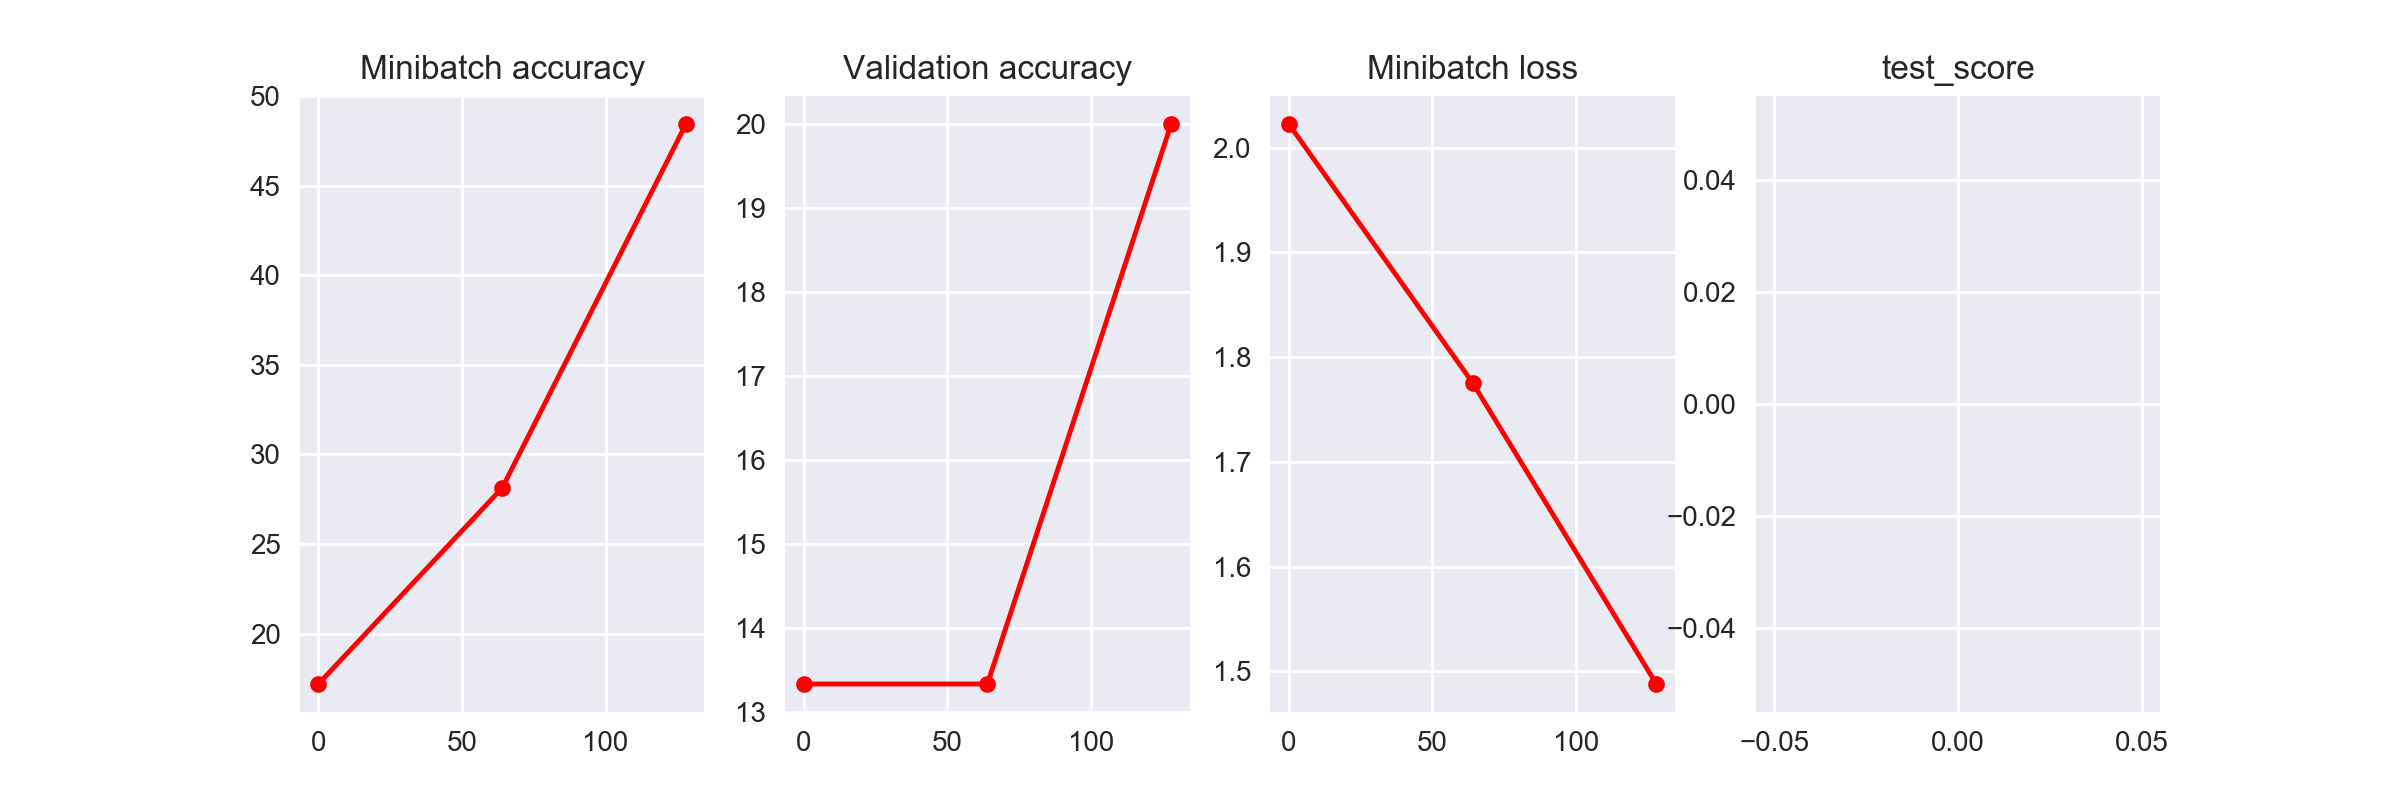


Time usage: 0:01:03
Iteration: 3


In [21]:
optimize(num_iterations=3)

In [29]:
# d1=jb.load('deep_checkpoints1/result_dict_w_l2_03_4000_64.pkl')

In [ ]:
#saver.restore(sess=session,save_path='checkpoints/33010_62')

In [ ]:
# test_predict=session.run(eval_pred, feed_dict={x: test_x})

# a=accuracy(test_predict,test_y)
# a

In [ ]:
# saver.save(sess=session, save_path='deep_checkpoints1/5000_deep_64')
# jb.dump(result_dict,'deep_checkpoints1/result_dict_5000_deep_64.pkl')
result_dict

In [19]:
test_score=[]

<IPython.core.display.Javascript object>


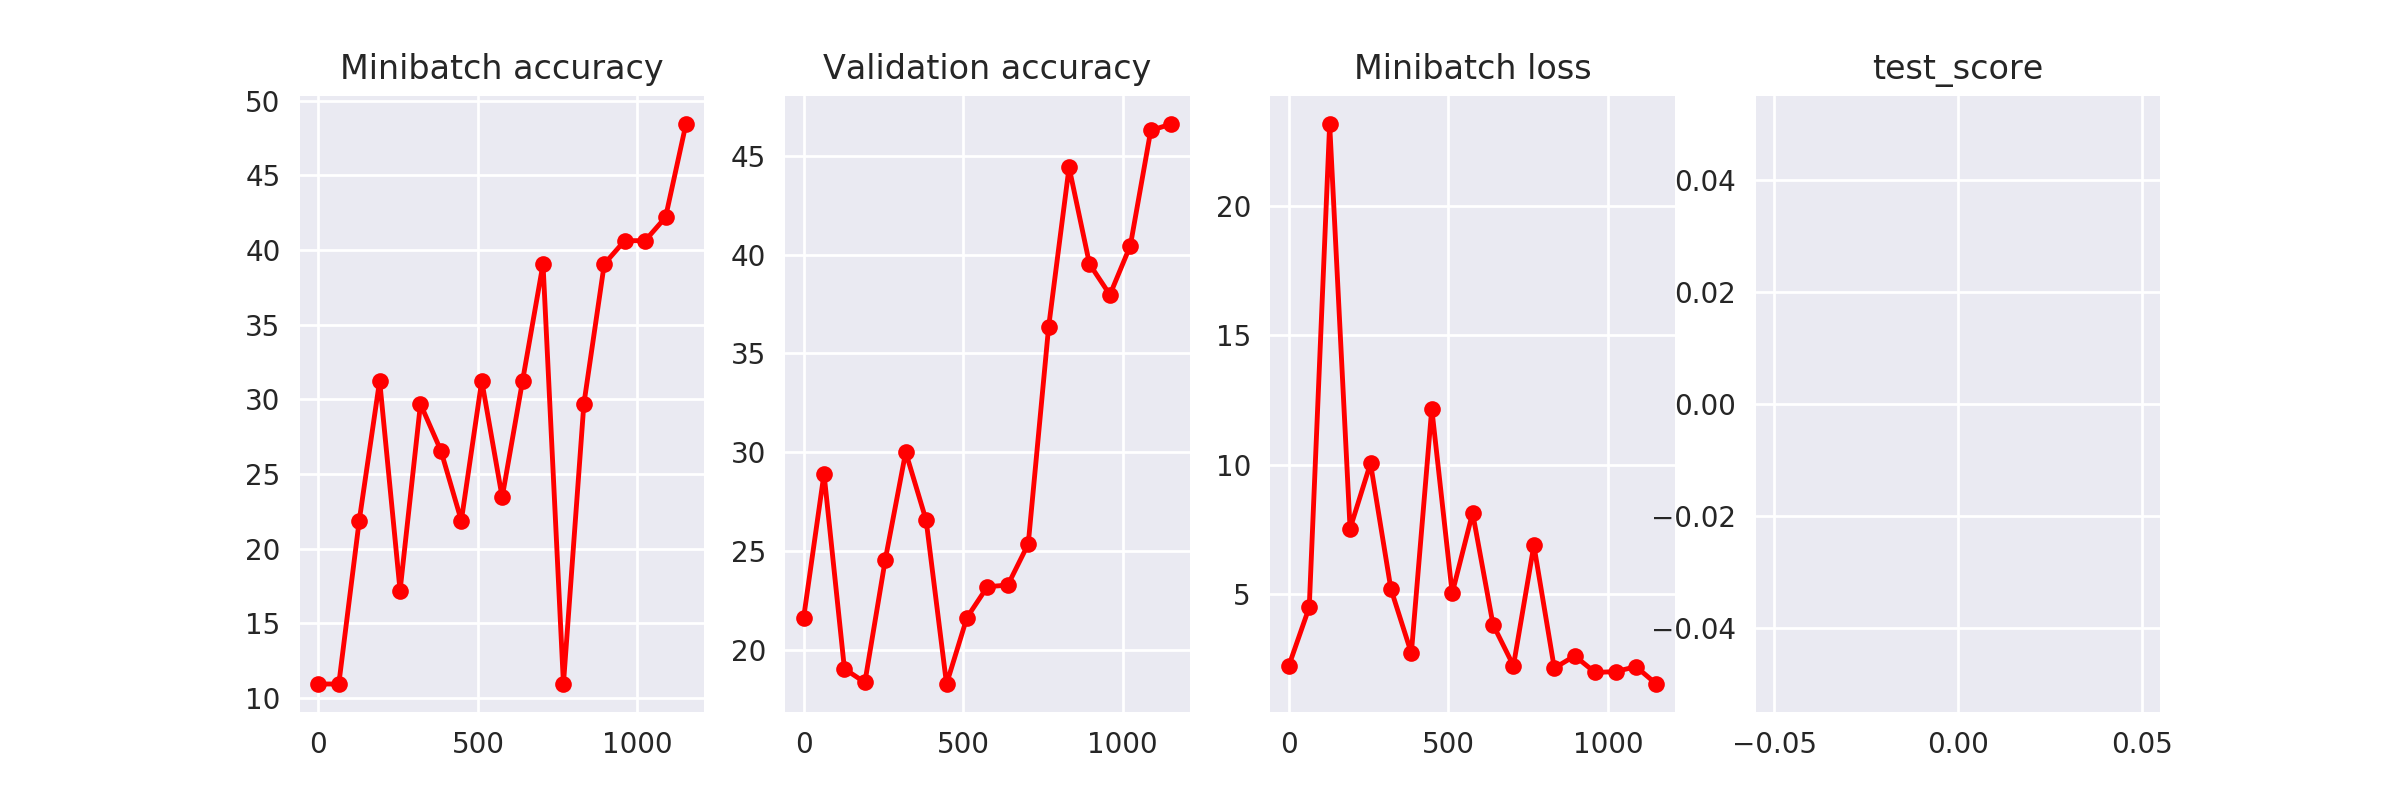

/home/theinhtay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



Time usage: 0:19:17
Iteration: 1000
Iteration =  1000


<IPython.core.display.Javascript object>


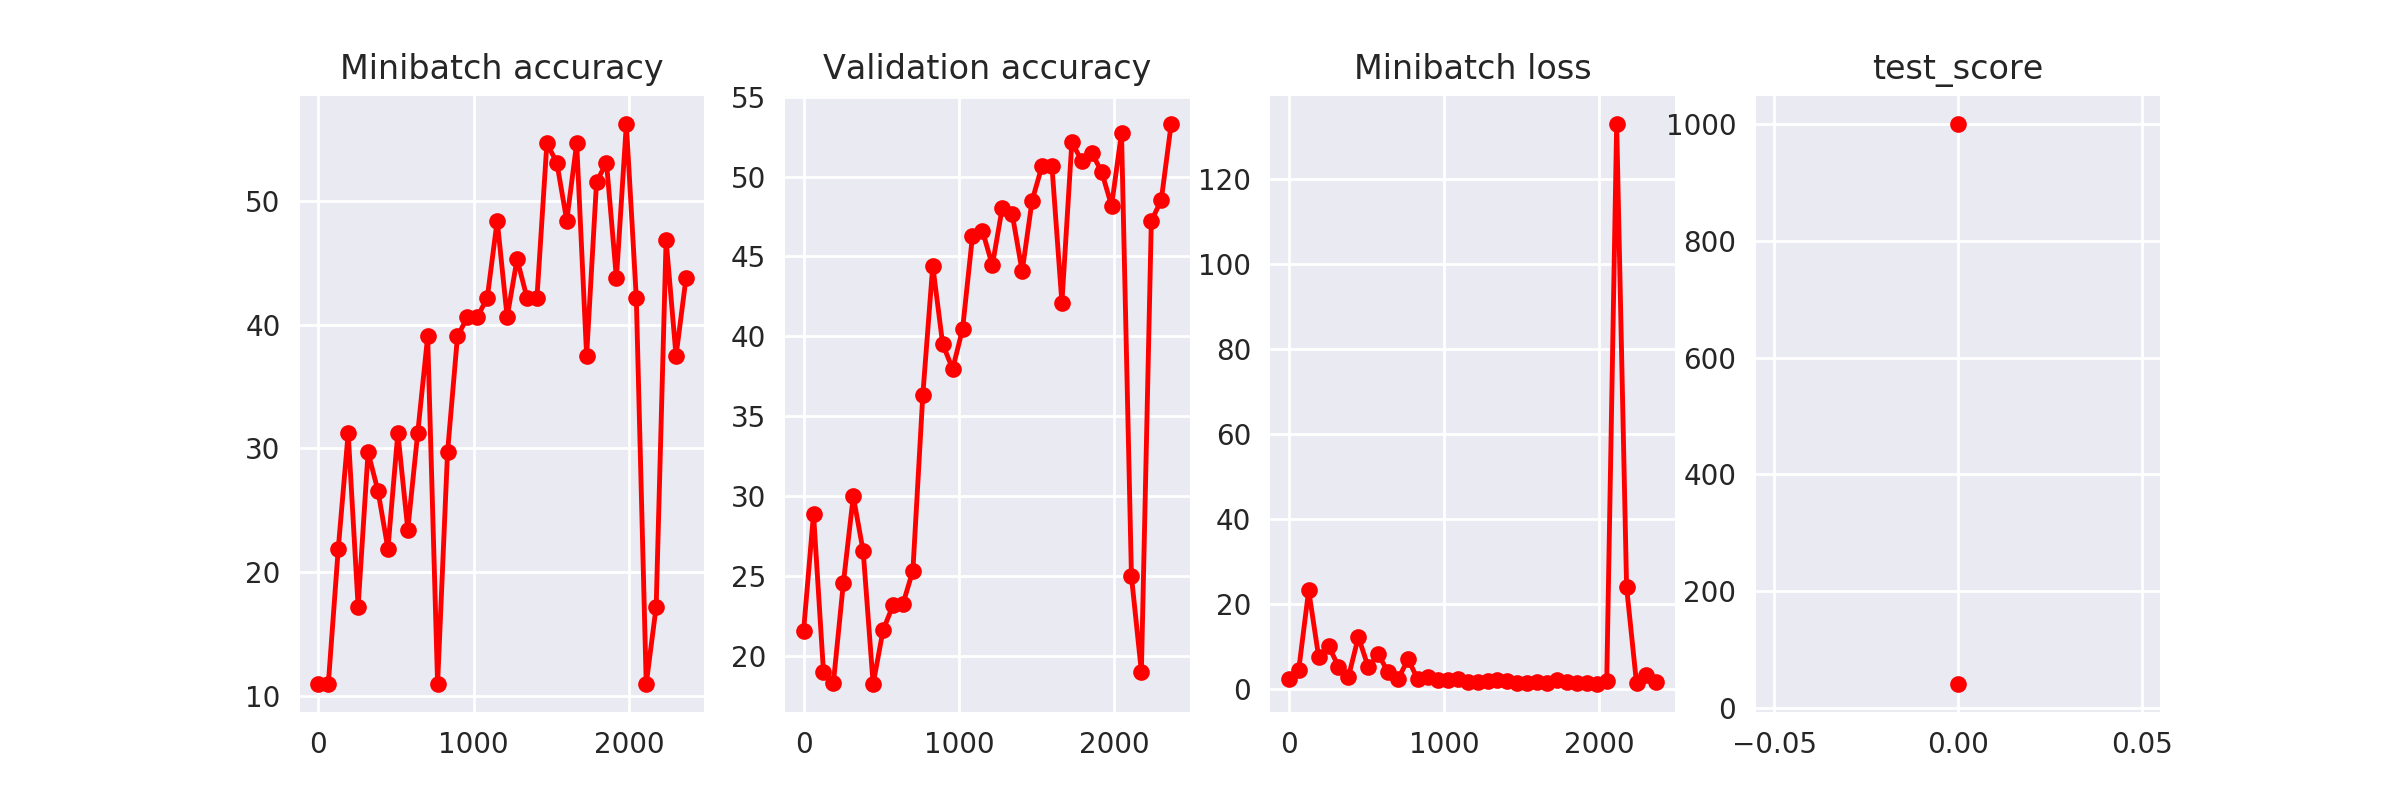


Time usage: 0:19:04
Iteration: 2000
Iteration =  2000


<IPython.core.display.Javascript object>


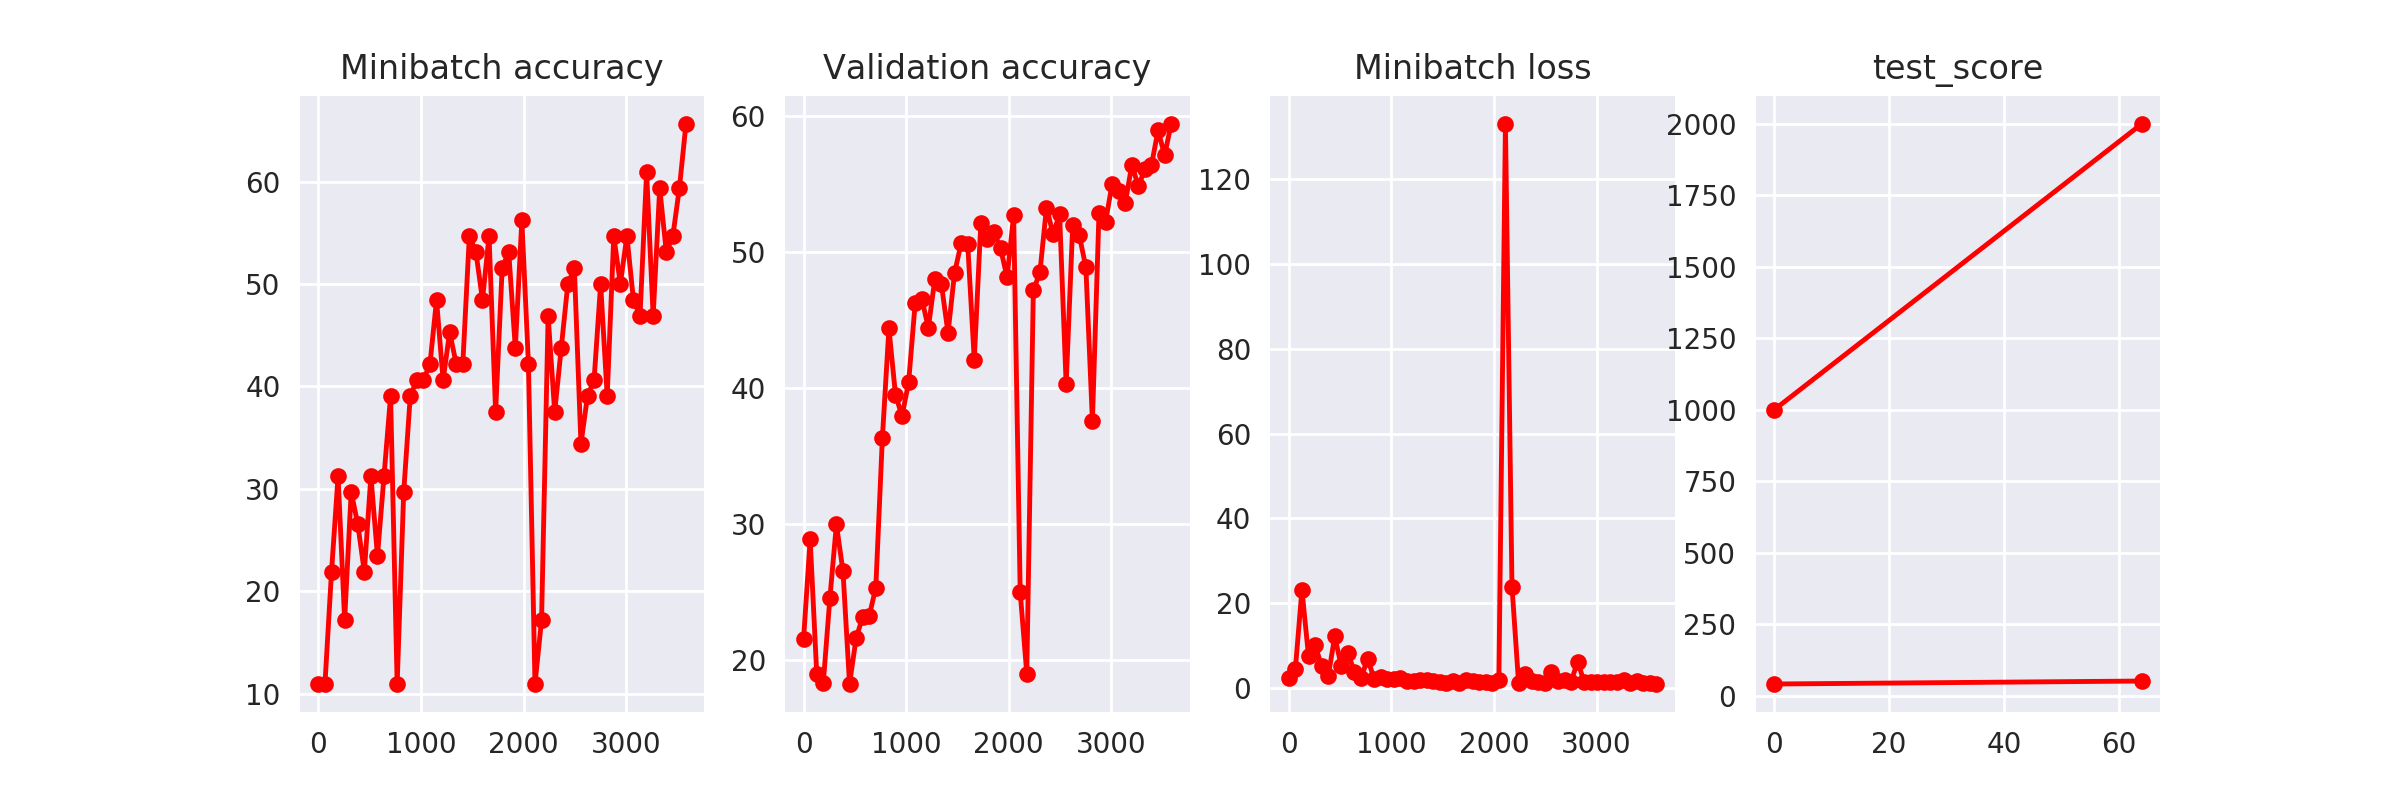


Time usage: 0:19:05
Iteration: 3000
Iteration =  3000


<IPython.core.display.Javascript object>


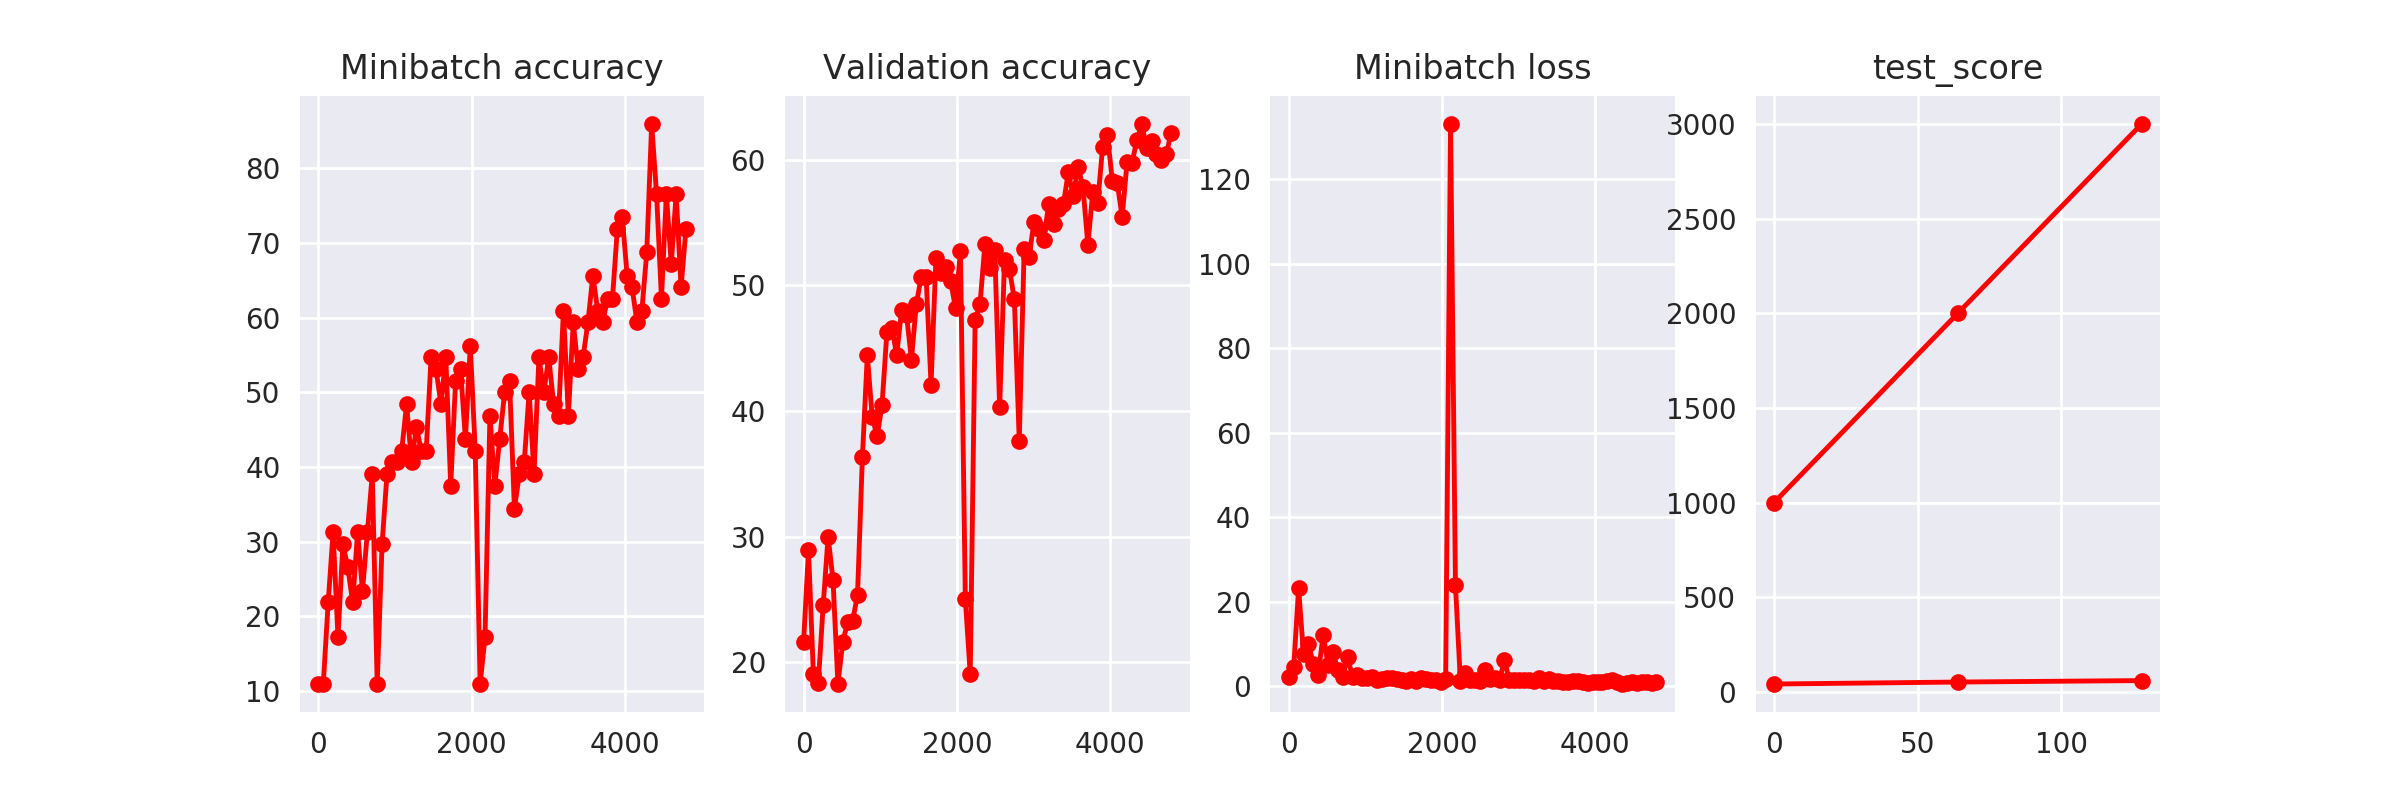


Time usage: 0:19:02
Iteration: 4000
Iteration =  4000


<IPython.core.display.Javascript object>


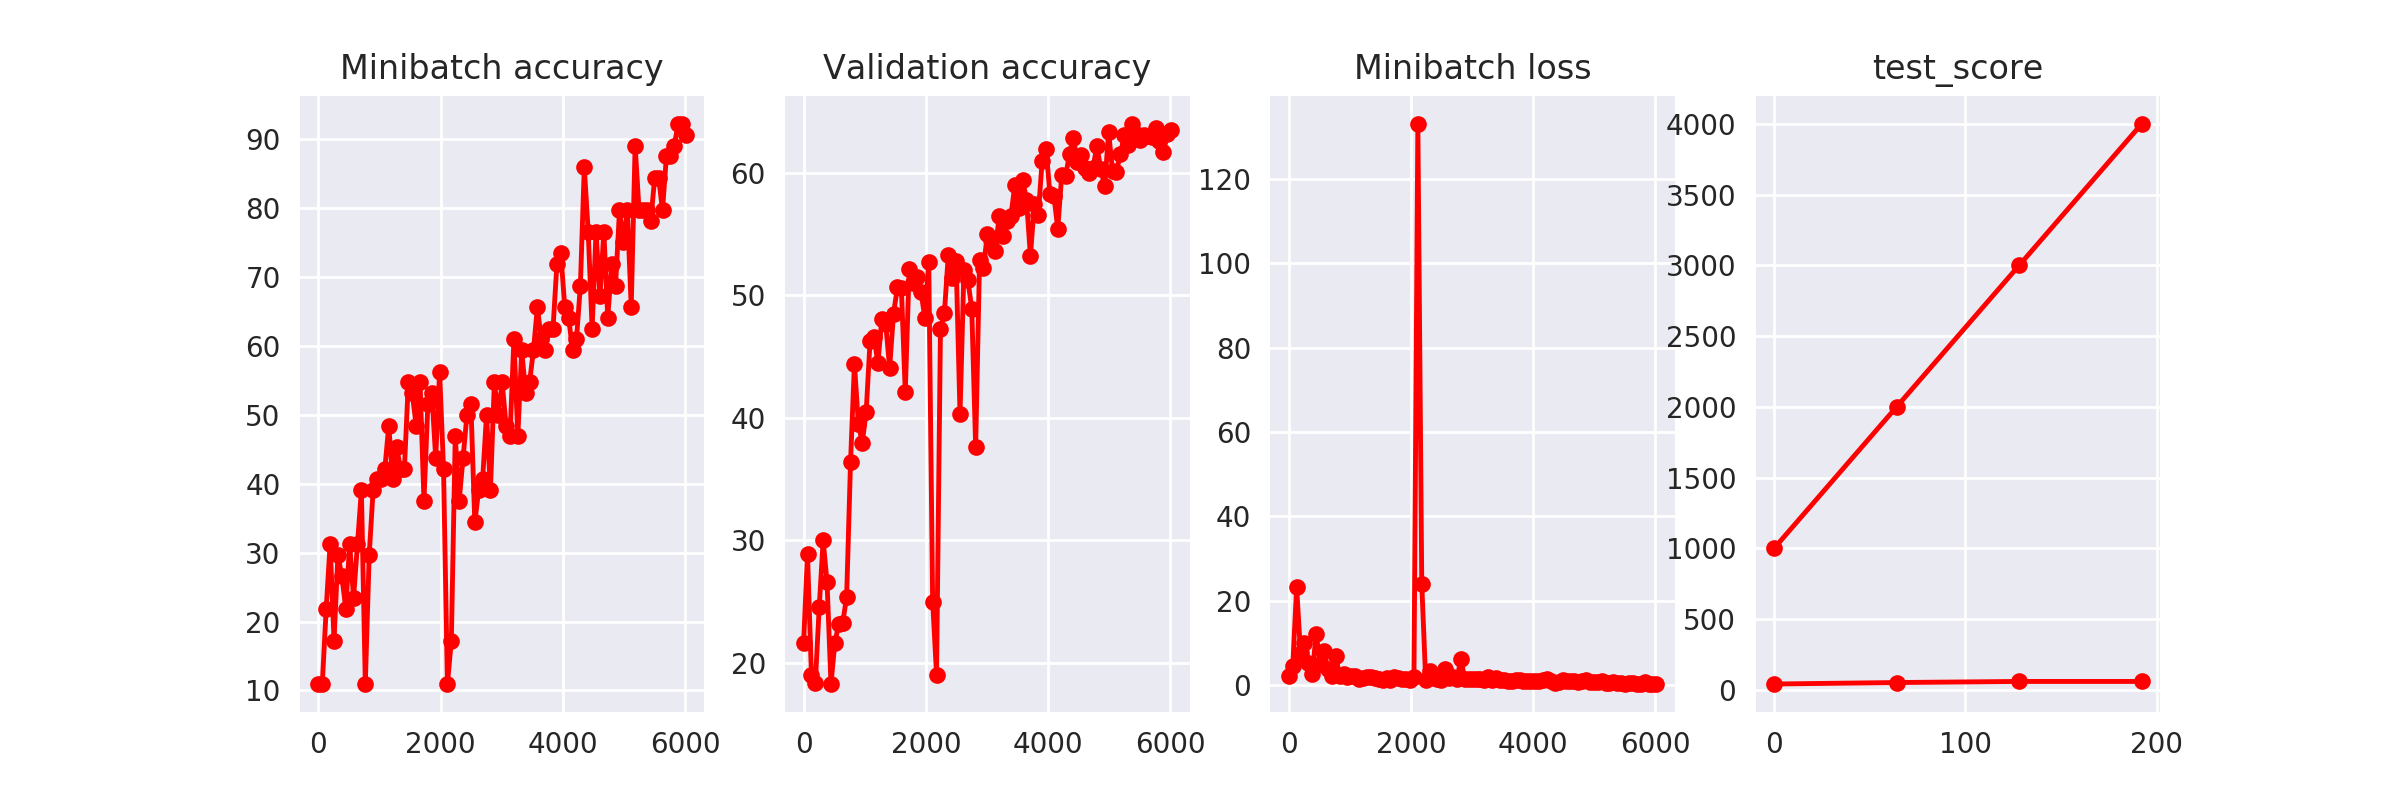


Time usage: 0:19:05
Iteration: 5000
Iteration =  5000


<IPython.core.display.Javascript object>


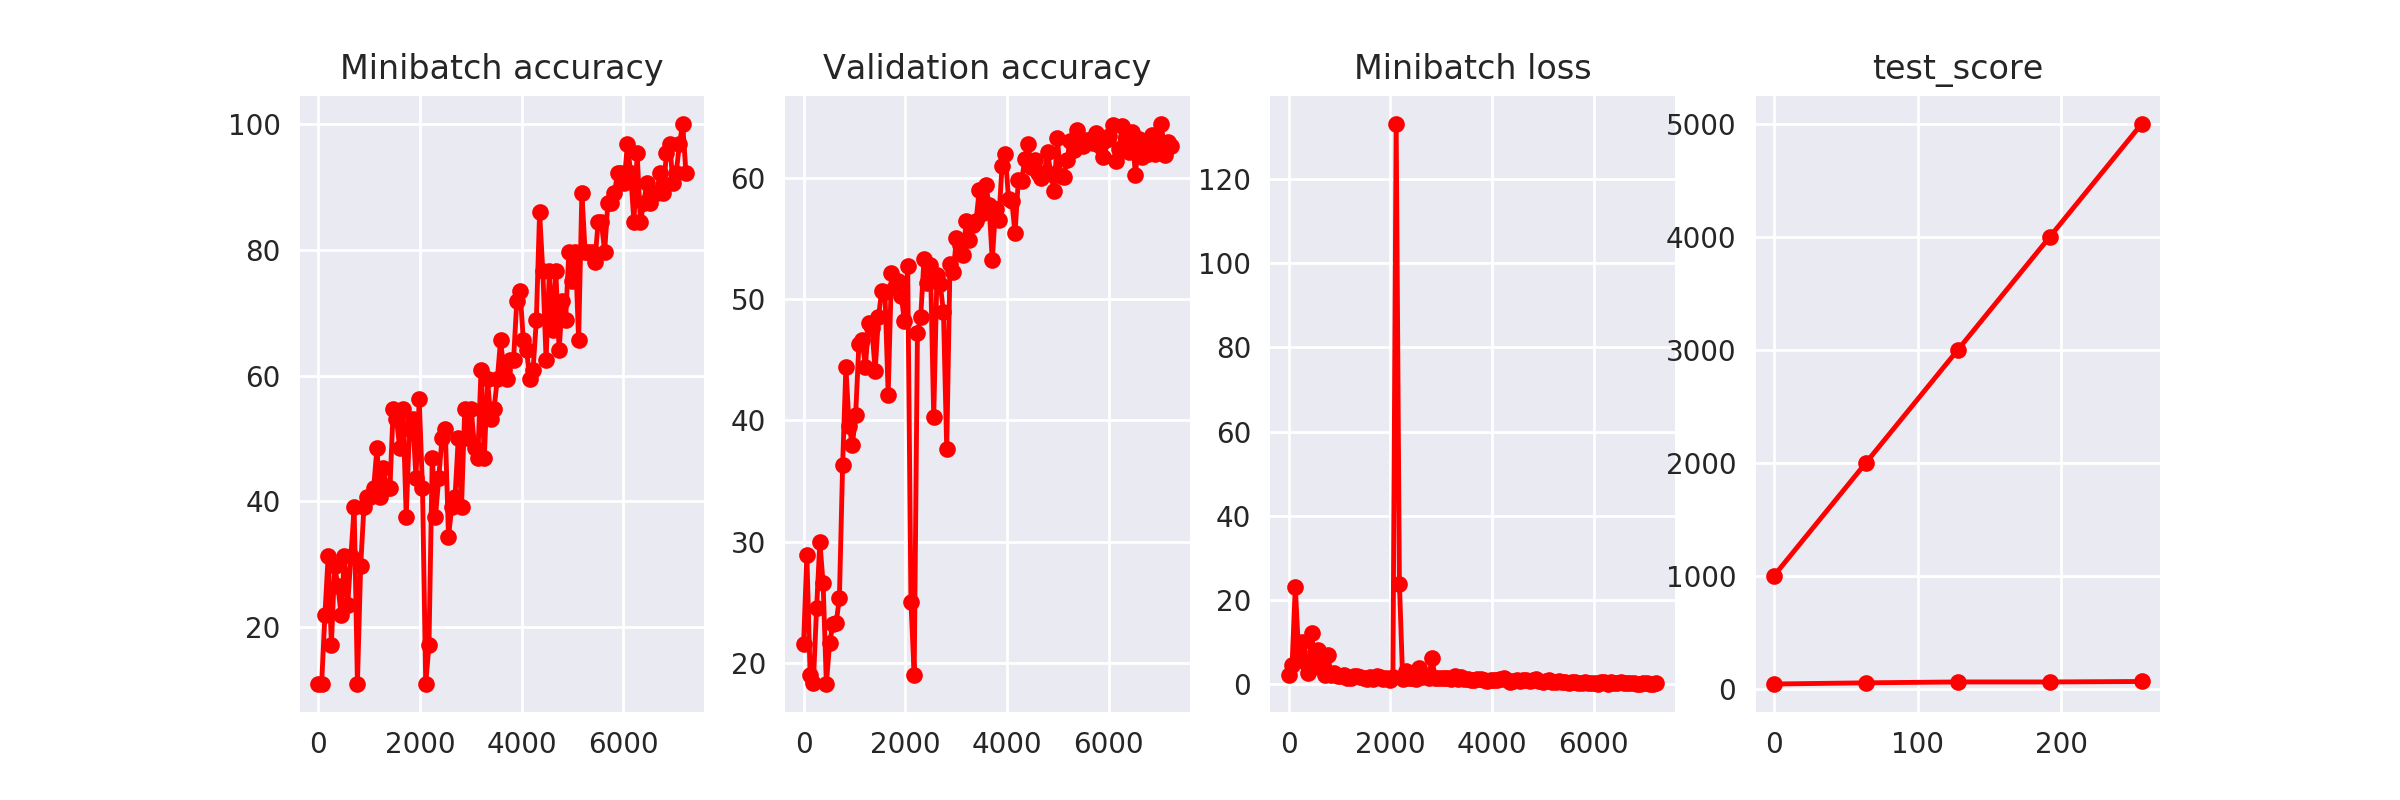


Time usage: 0:19:05
Iteration: 6000
Iteration =  6000


<IPython.core.display.Javascript object>


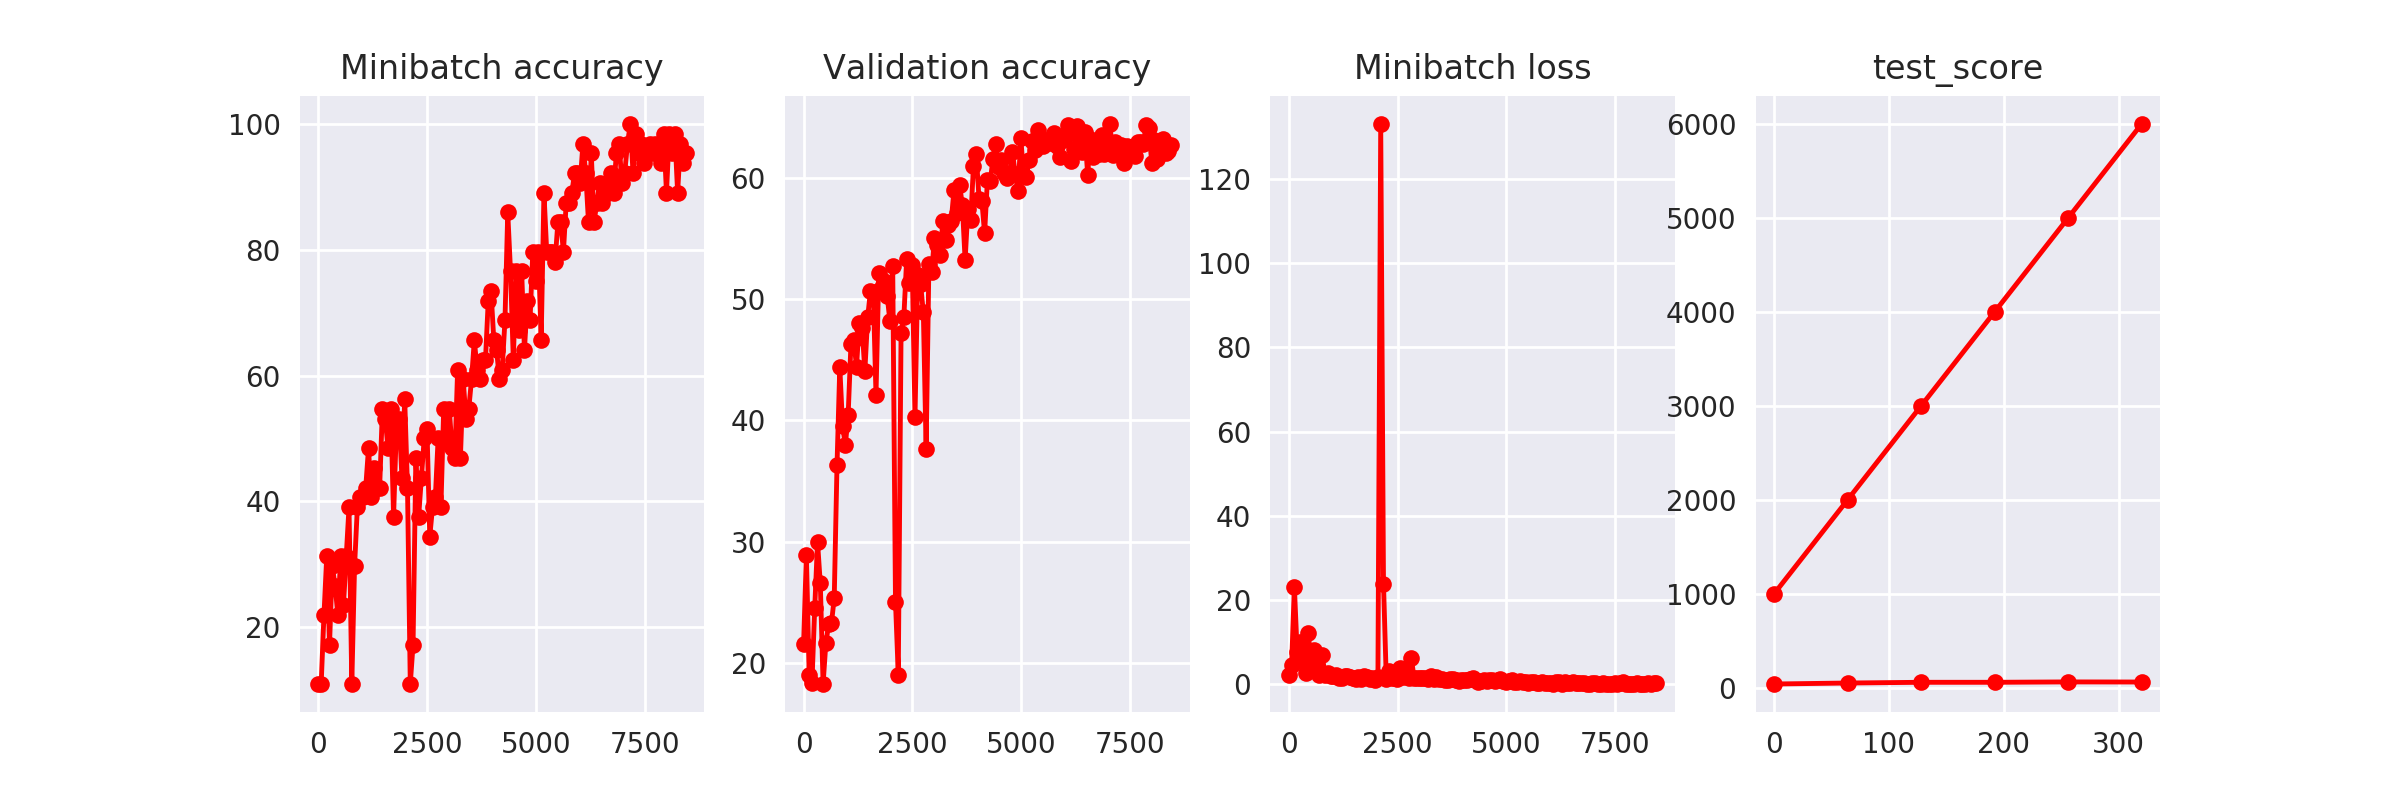


Time usage: 0:19:05
Iteration: 7000
Iteration =  7000


<IPython.core.display.Javascript object>


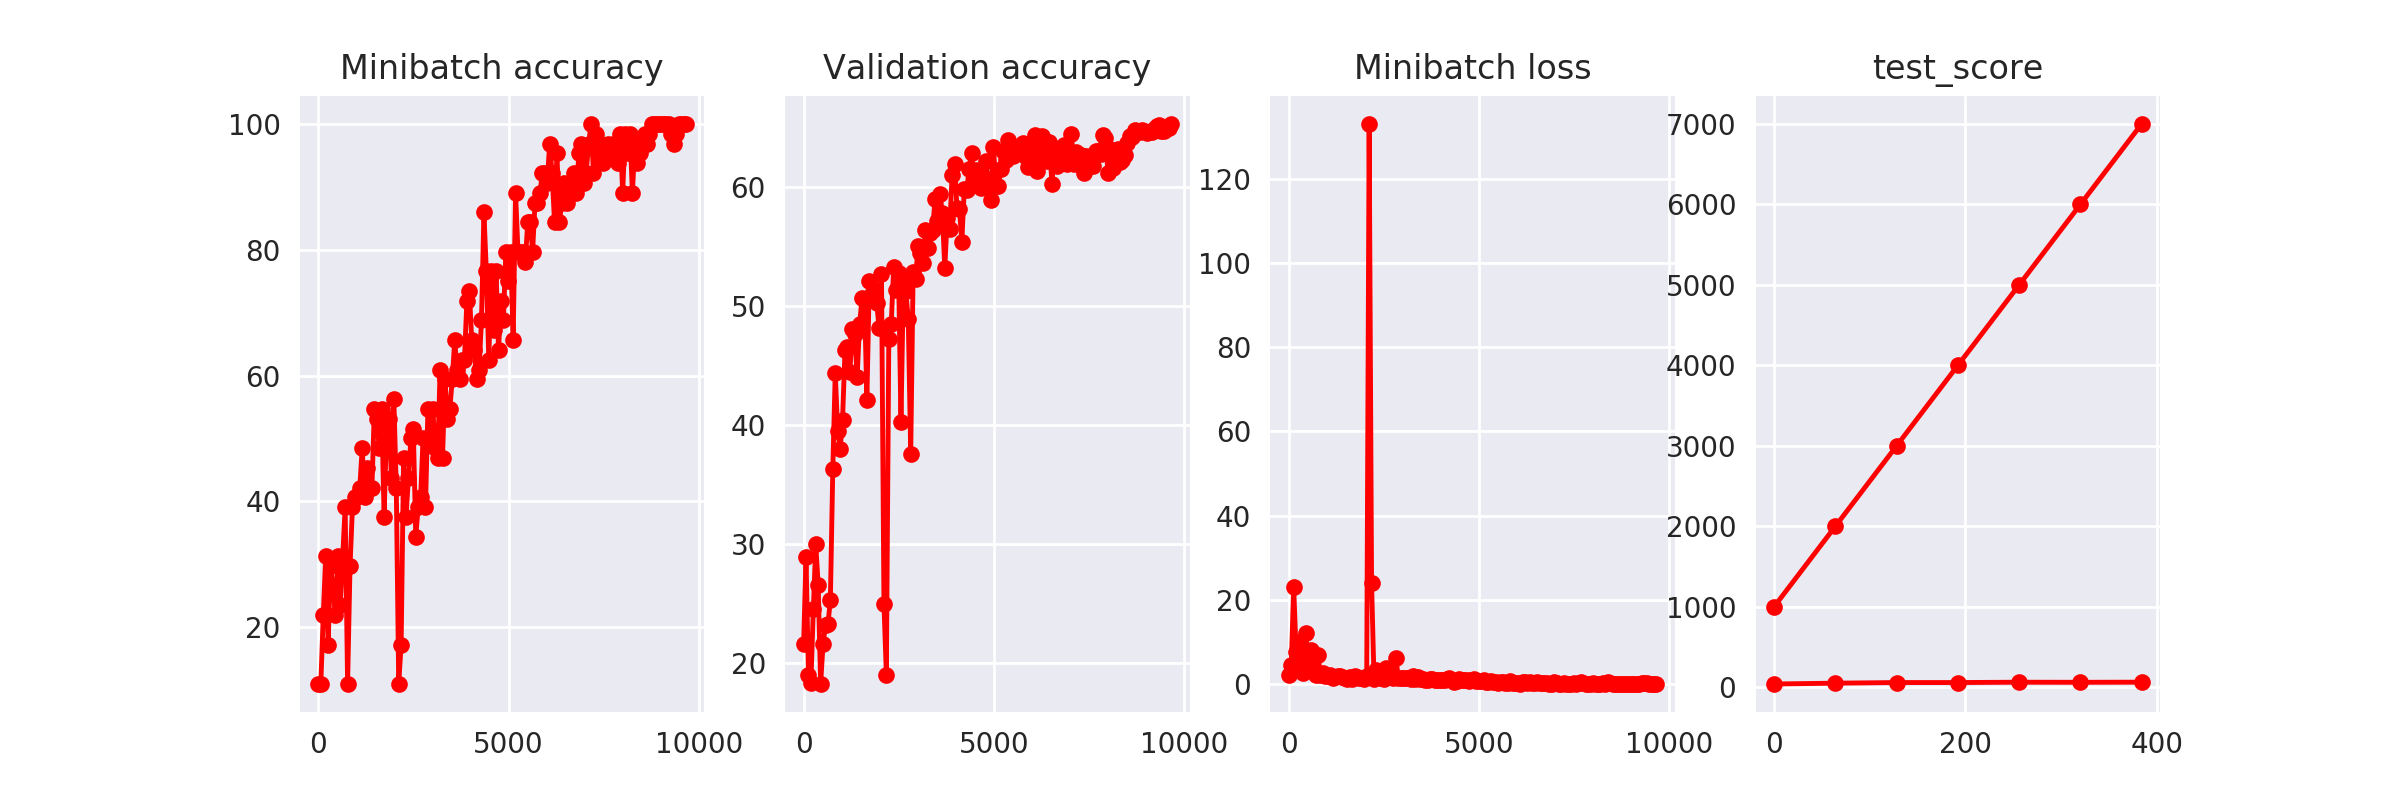


Time usage: 0:19:04
Iteration: 8000
Iteration =  8000


<IPython.core.display.Javascript object>


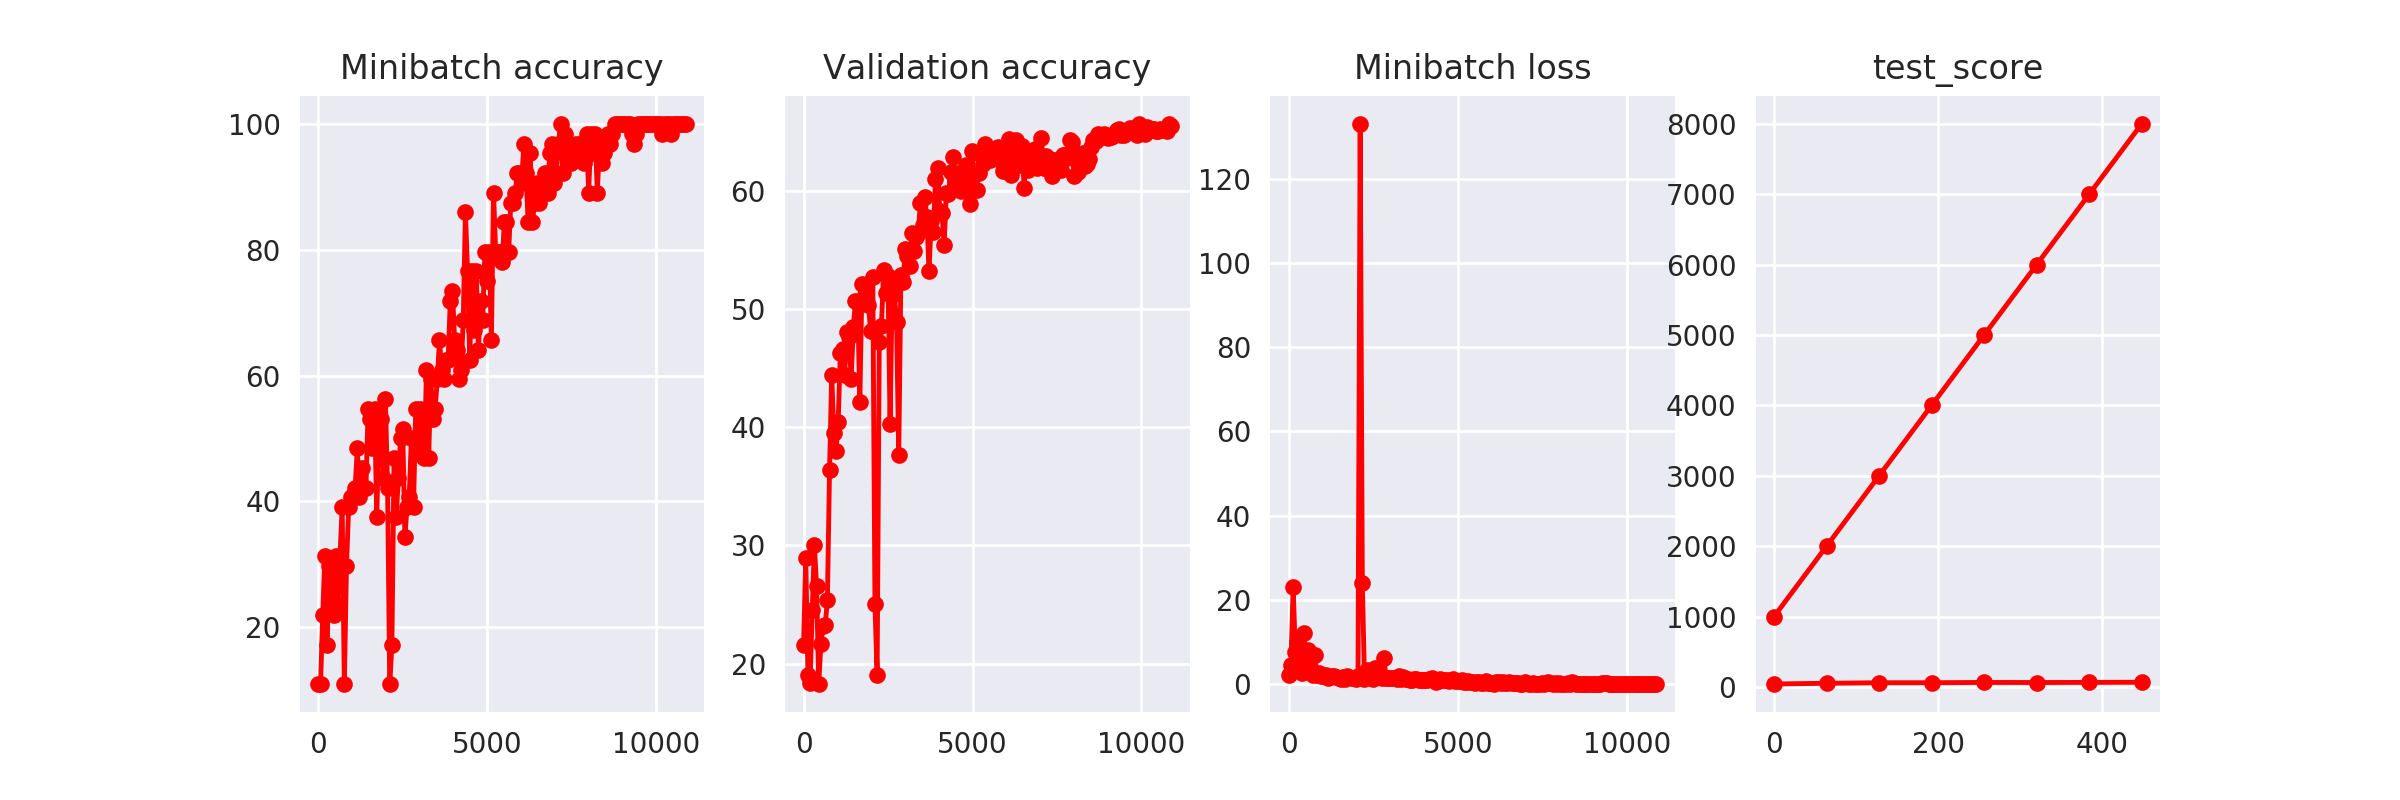


Time usage: 0:19:04
Iteration: 9000
Iteration =  9000


<IPython.core.display.Javascript object>


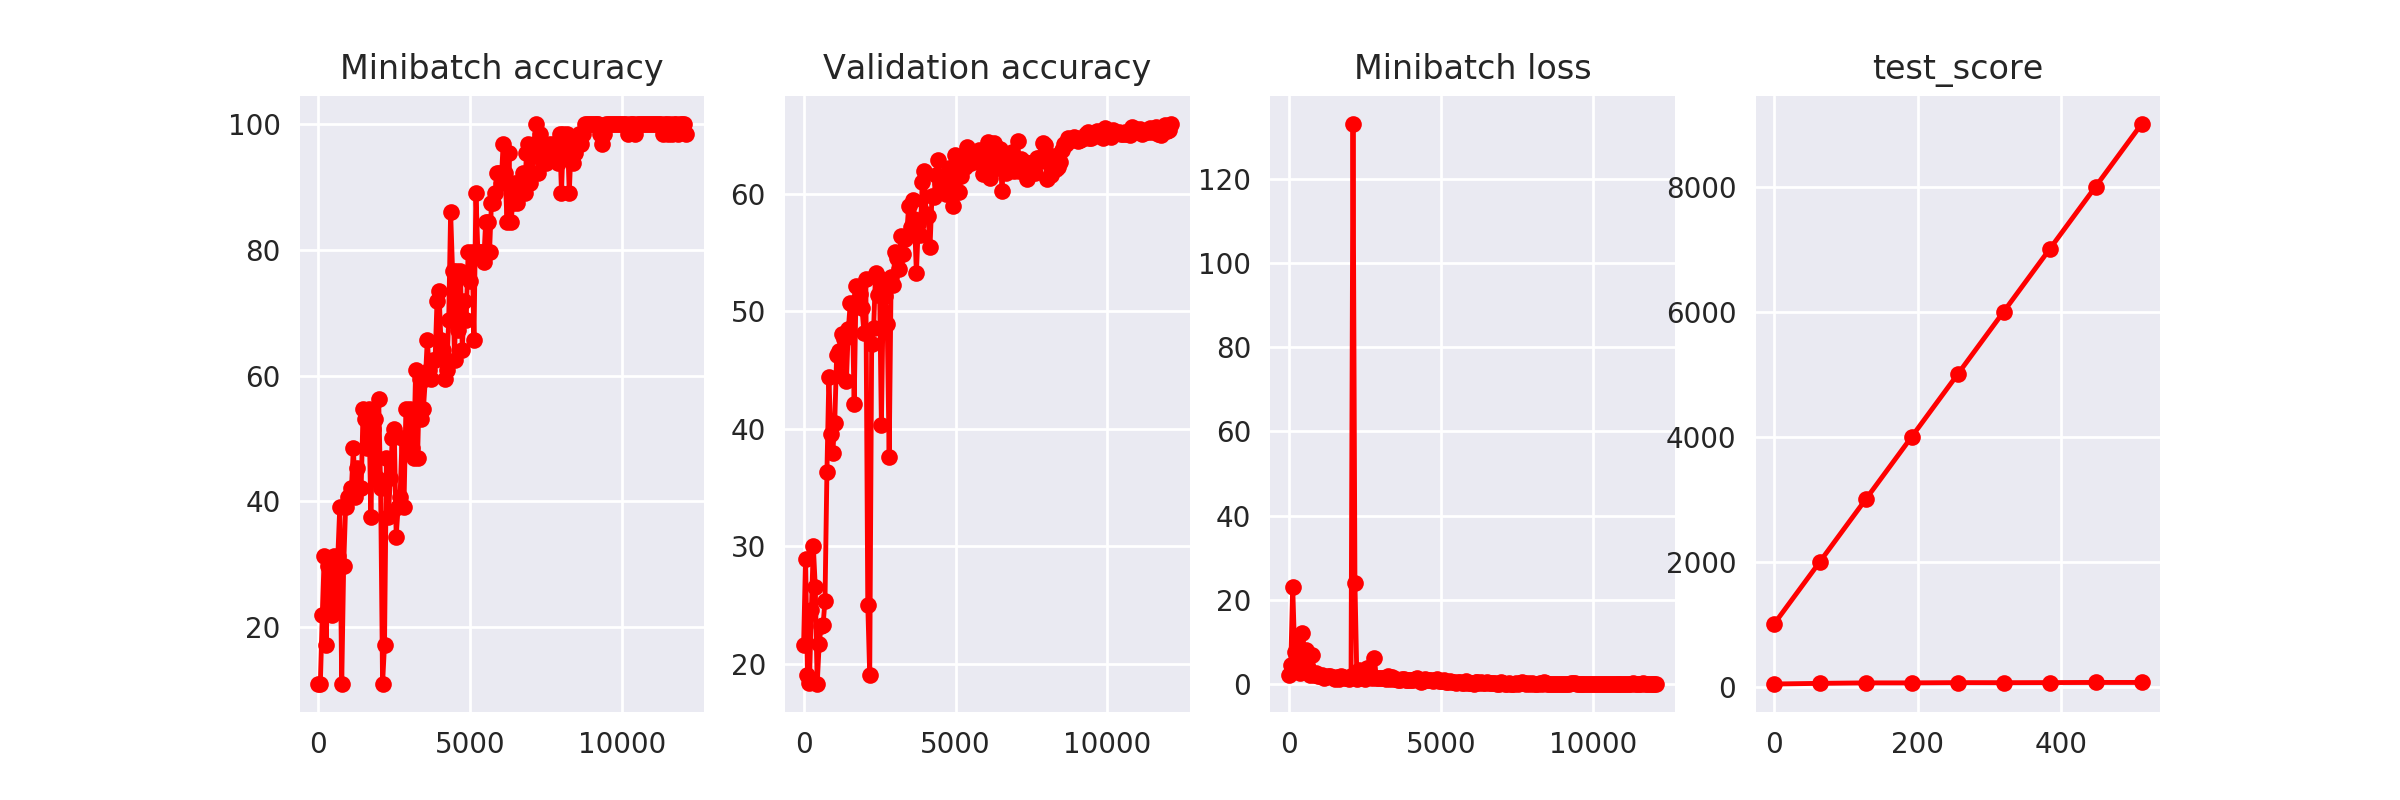


Time usage: 0:19:03
Iteration: 10000
Iteration =  10000


<IPython.core.display.Javascript object>


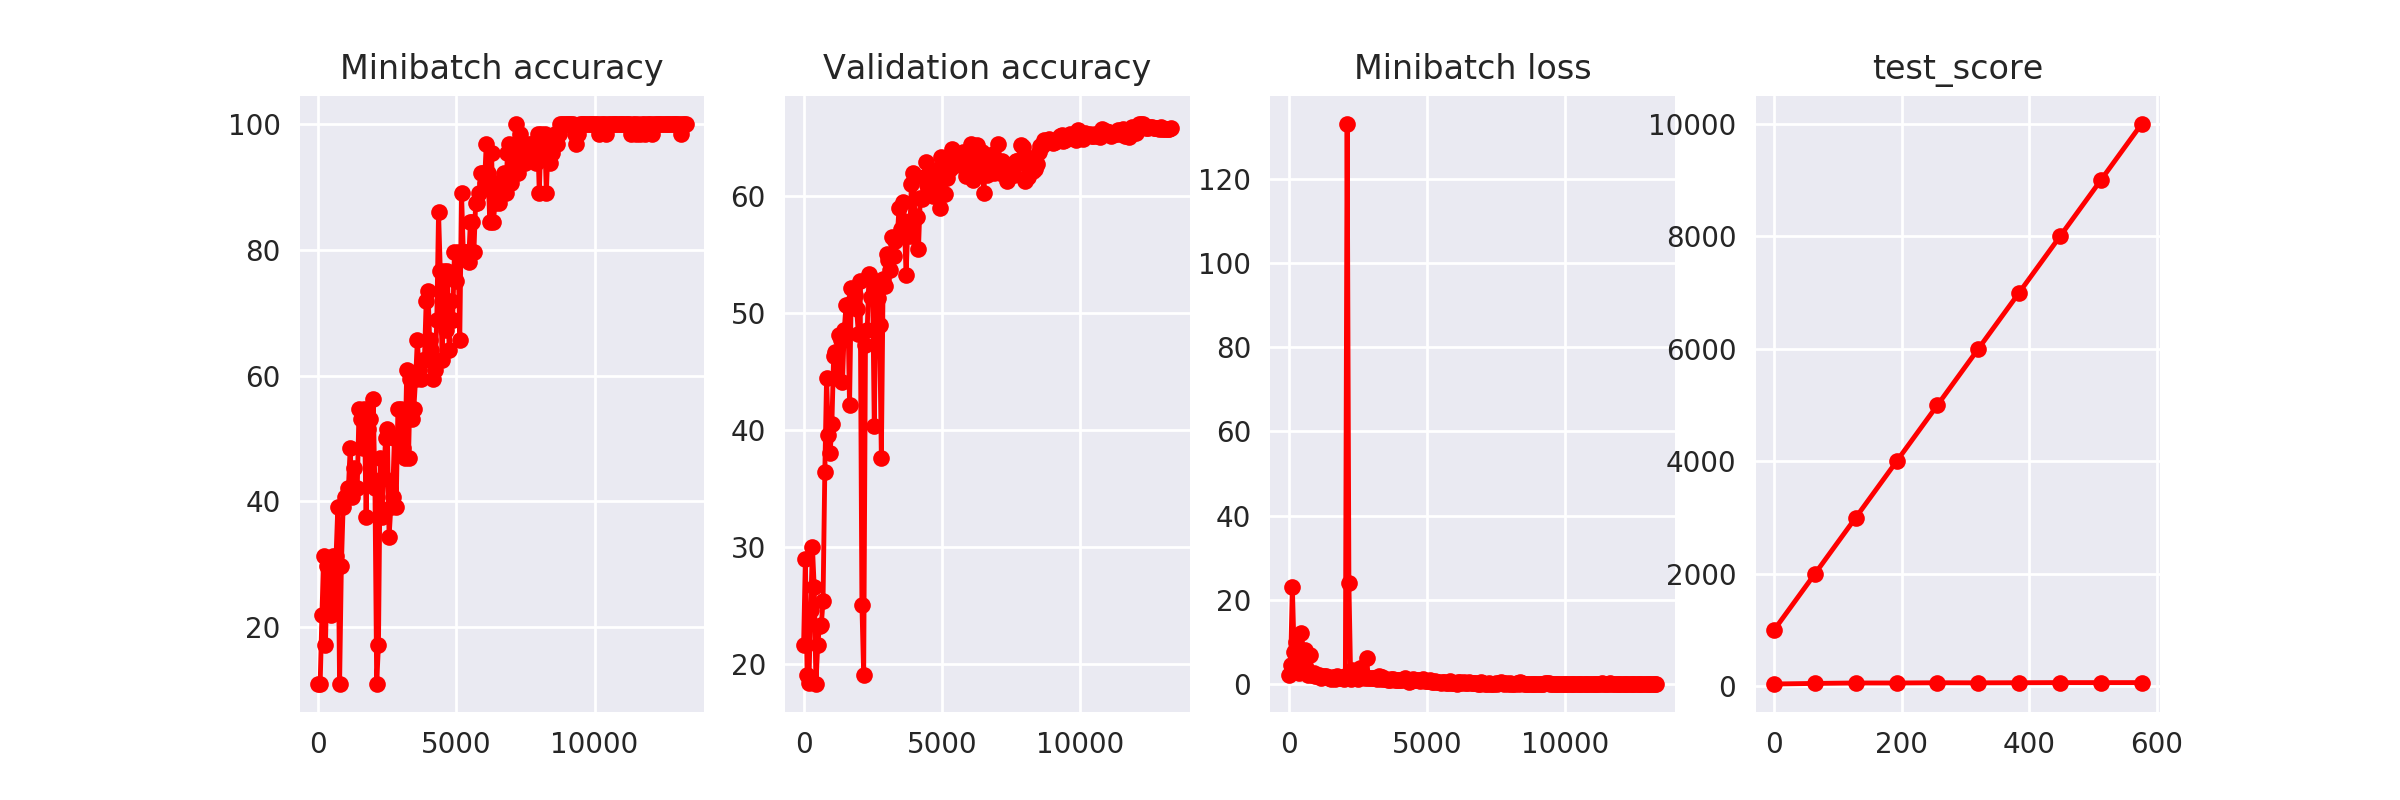


Time usage: 0:19:04
Iteration: 11000
Iteration =  11000


<IPython.core.display.Javascript object>


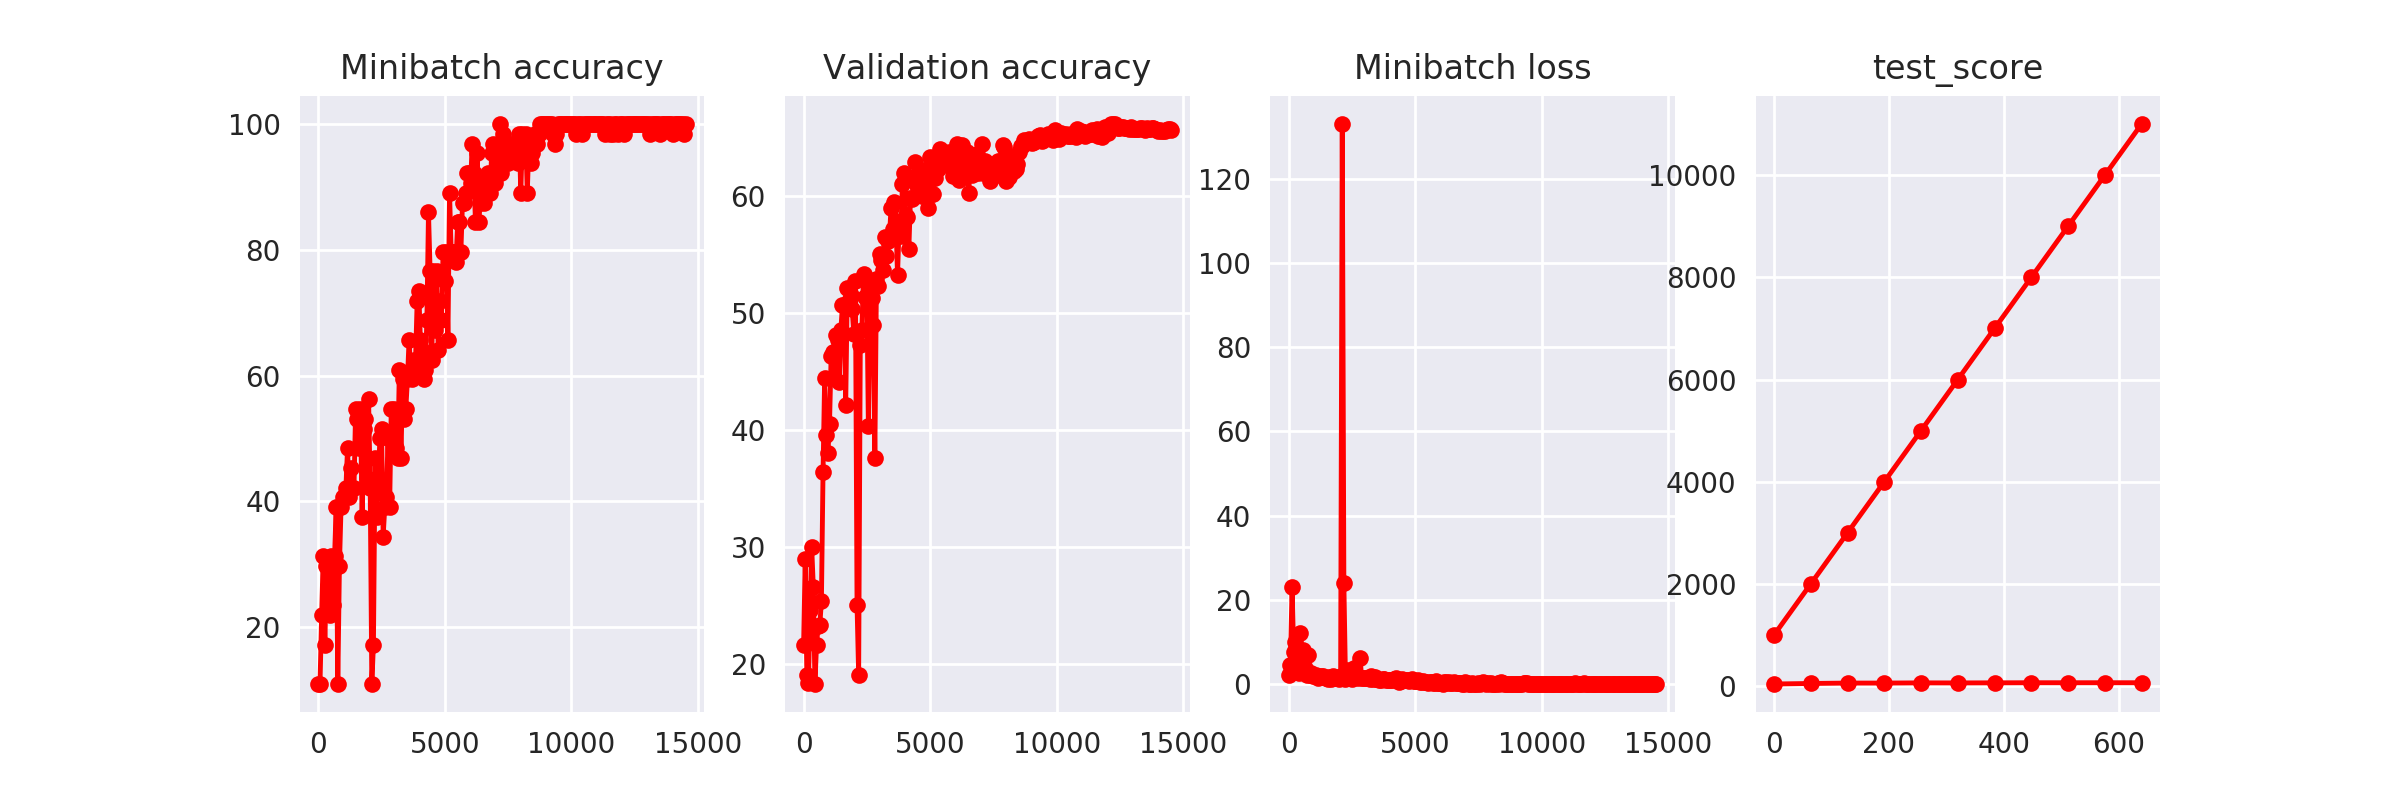


Time usage: 0:19:04
Iteration: 12000
Iteration =  12000


<IPython.core.display.Javascript object>


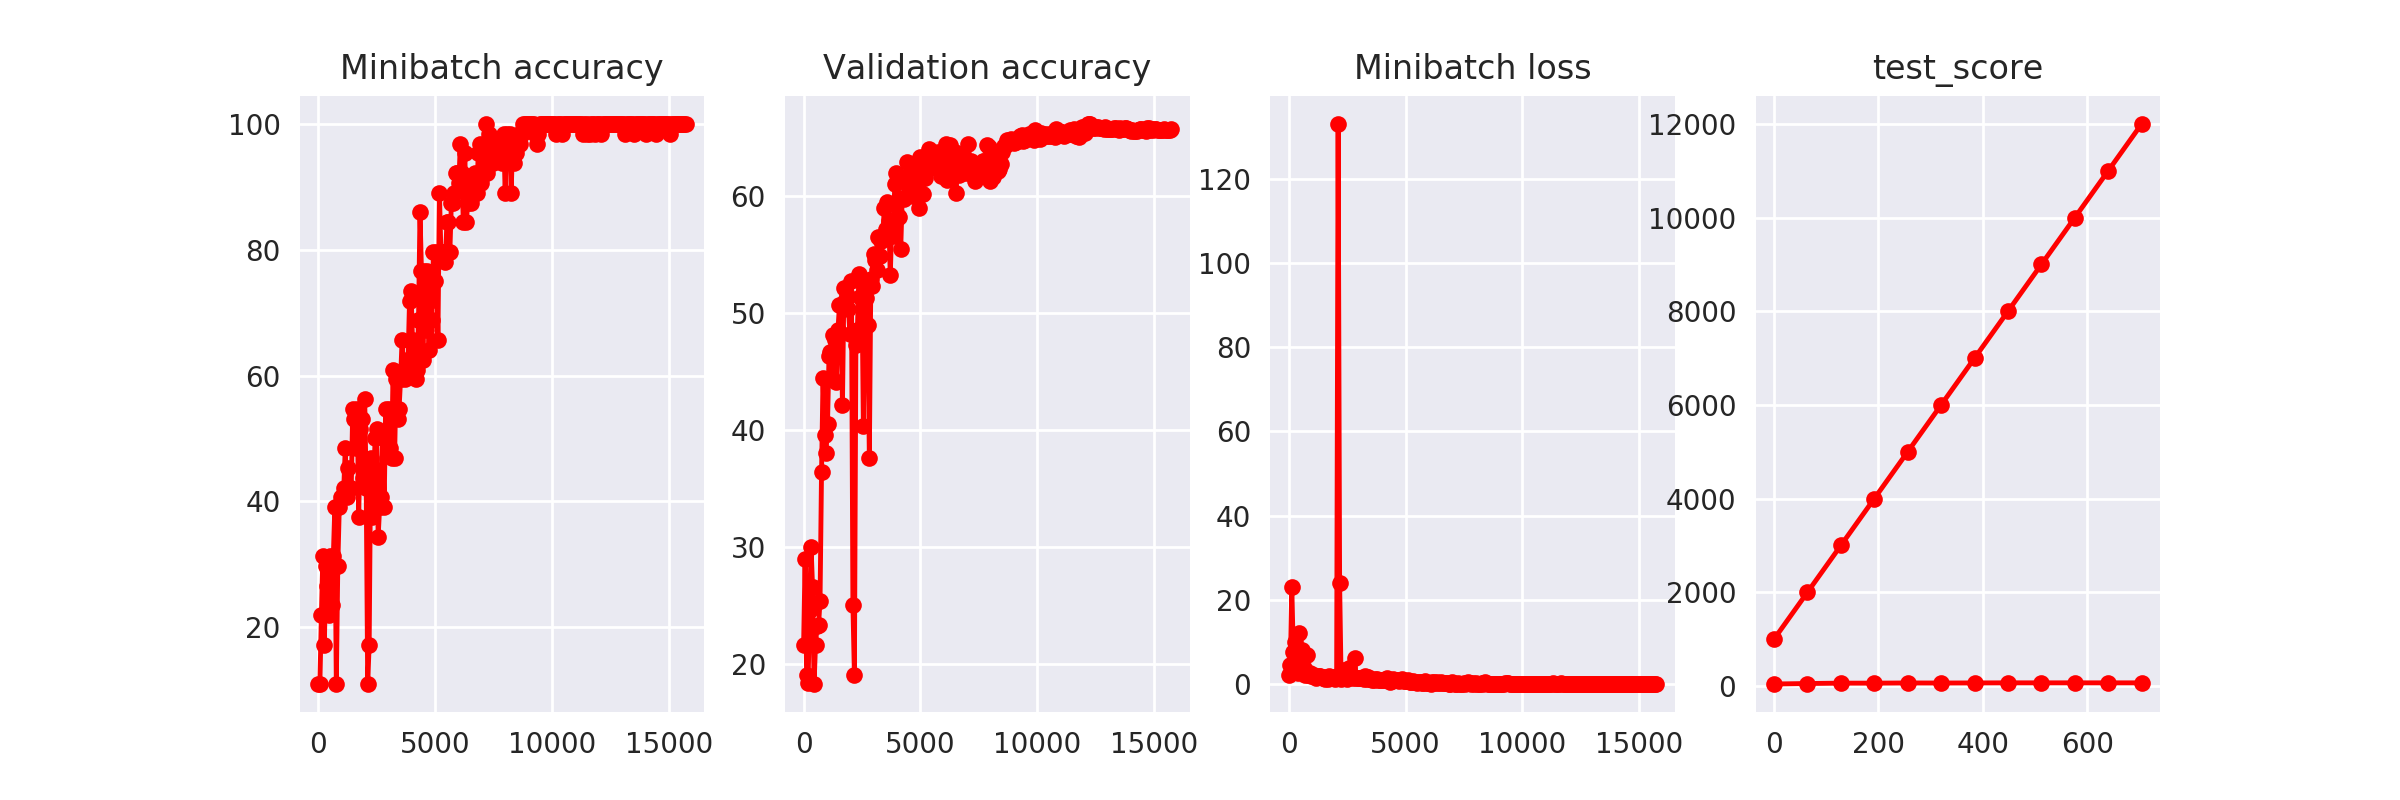


Time usage: 0:19:05
Iteration: 13000
Iteration =  13000


<IPython.core.display.Javascript object>


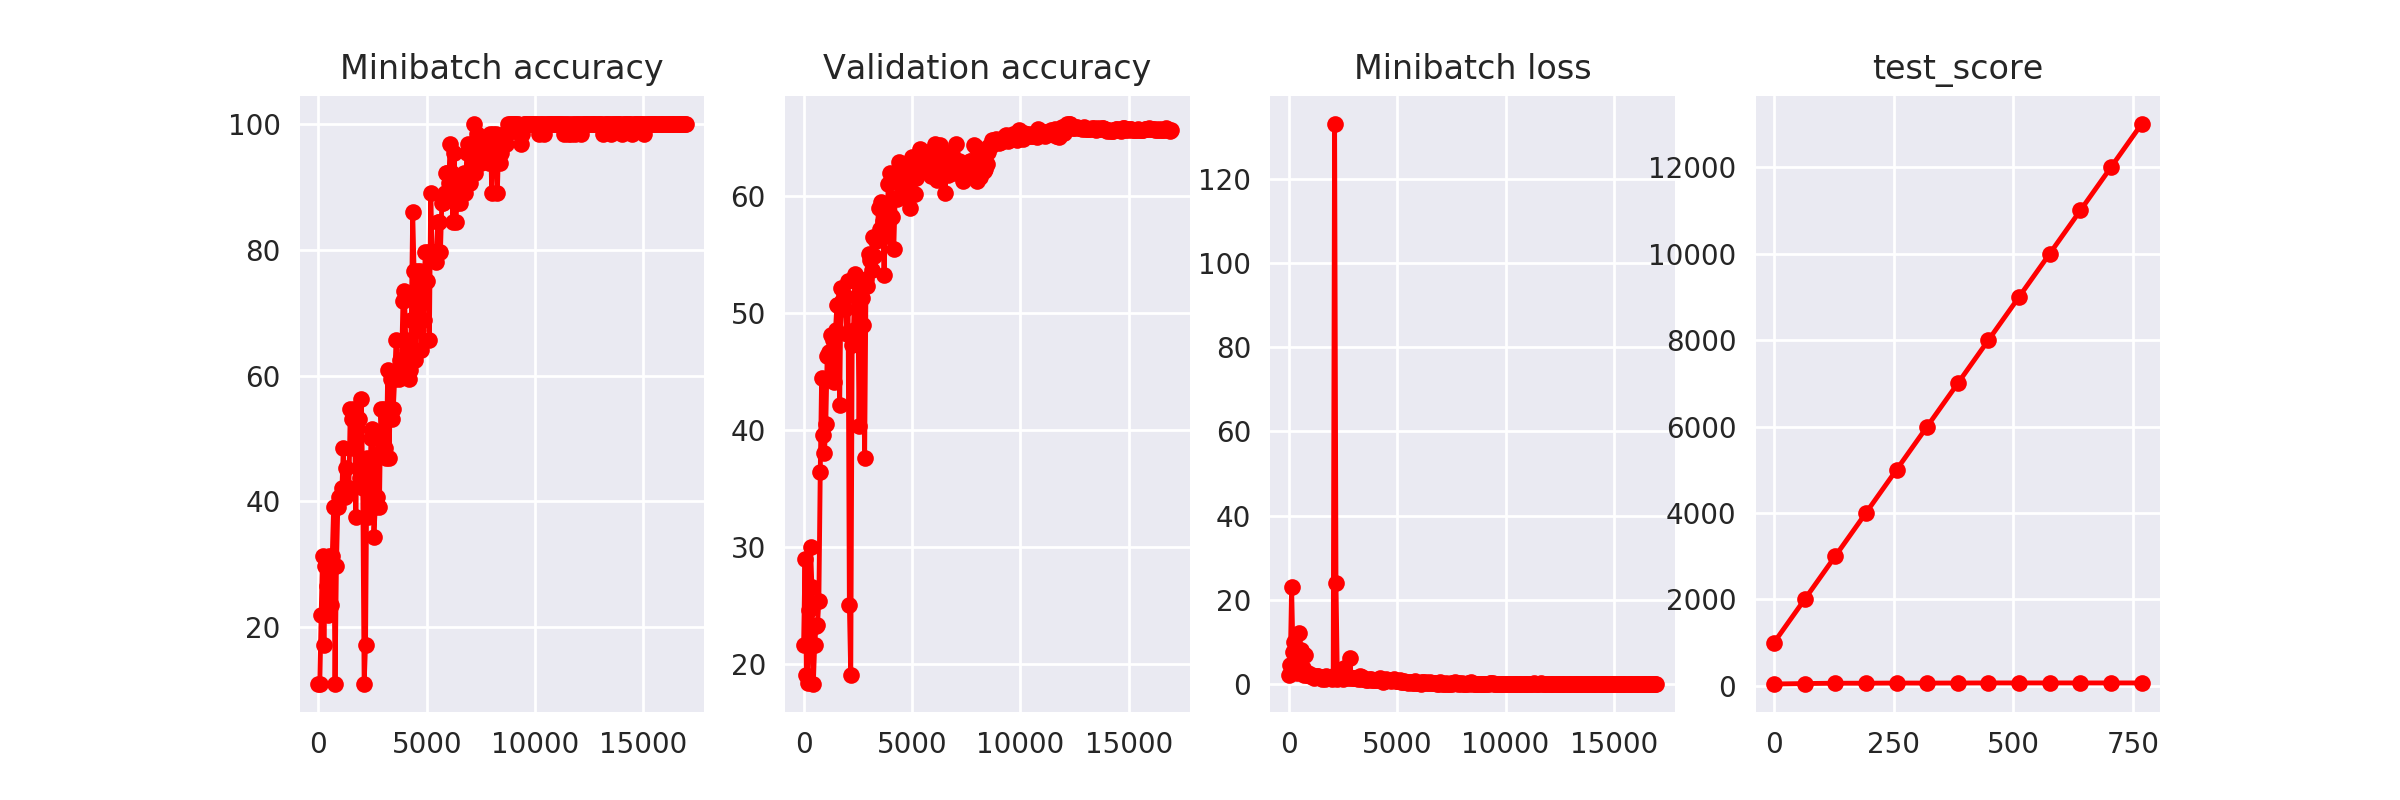


Time usage: 0:19:06
Iteration: 14000
Iteration =  14000


In [20]:
for i in range(14):
    optimize(num_iterations=1000)
    test_predict=session.run(eval_pred, feed_dict={x: test_x})
    a=accuracy(test_predict,test_y)
    result_dict['test_score'].append([inc,a])
    acc=int(np.round(a))
    fname='{}_{}'.format(str(inc),str(acc))
    #saver.save(sess=session, save_path='checkpoints/'+fname)
    str_path='deep_checkpoints3/new1_'
    jb.dump(result_dict,str_path+fname+'.pkl')
    saver.save(sess=session, save_path=str_path+fname)
    print("Iteration = ",str(inc))

In [21]:
test_predict=session.run(eval_pred, feed_dict={x: test_x})

a=accuracy(test_predict,test_y)
a

65.937072503419969

In [ ]:
#optimize(num_iterations=10000)
#saver.save(sess=session, save_path='checkpoints/30000_second_model_63')

In [ ]:
#saver.restore(sess=session, save_path='checkpoints/10000_second_model_64')
##!tensorboard --logdir="logs"

In [ ]:
#!tensorboard --logdir="logs"

In [ ]:
import joblib as jb

In [ ]:
jb.load('../test.pkl')

In [23]:
jb.dump(result_dict,'total_result_dict.pkl')

['total_result_dict.pkl']

In [22]:
result_dict

{'Minibatch accuracy': [10.9375,
  10.9375,
  21.875,
  31.25,
  17.1875,
  29.6875,
  26.5625,
  21.875,
  31.25,
  23.4375,
  31.25,
  39.0625,
  10.9375,
  29.6875,
  39.0625,
  40.625,
  40.625,
  42.1875,
  48.4375,
  40.625,
  45.3125,
  42.1875,
  42.1875,
  54.6875,
  53.125,
  48.4375,
  54.6875,
  37.5,
  51.5625,
  53.125,
  43.75,
  56.25,
  42.1875,
  10.9375,
  17.1875,
  46.875,
  37.5,
  43.75,
  50.0,
  51.5625,
  34.375,
  39.0625,
  40.625,
  50.0,
  39.0625,
  54.6875,
  50.0,
  54.6875,
  48.4375,
  46.875,
  60.9375,
  46.875,
  59.375,
  53.125,
  54.6875,
  59.375,
  65.625,
  60.9375,
  59.375,
  62.5,
  62.5,
  71.875,
  73.4375,
  65.625,
  64.0625,
  59.375,
  60.9375,
  68.75,
  85.9375,
  76.5625,
  62.5,
  76.5625,
  67.1875,
  76.5625,
  64.0625,
  71.875,
  68.75,
  79.6875,
  75.0,
  79.6875,
  65.625,
  89.0625,
  79.6875,
  79.6875,
  79.6875,
  78.125,
  84.375,
  84.375,
  79.6875,
  87.5,
  87.5,
  89.0625,
  92.1875,
  92.1875,
  90.625,
  96.875

In [24]:
test_data={'test_x':test_x,'test_y': test_y}
jb.dump(test_data,'test_data.pickle')

['test_data.pickle']

In [27]:
model_list=[i[:-6] for i in glob('deep_checkpoints3/new1_*.index')]
model_list

['deep_checkpoints3/new1_1000_41',
 'deep_checkpoints3/new1_12000_66',
 'deep_checkpoints3/new1_2000_52',
 'deep_checkpoints3/new1_14000_66',
 'deep_checkpoints3/new1_6000_62',
 'deep_checkpoints3/new1_4000_59',
 'deep_checkpoints3/new1_11000_66',
 'deep_checkpoints3/new1_3000_59',
 'deep_checkpoints3/new1_7000_64',
 'deep_checkpoints3/new1_8000_66',
 'deep_checkpoints3/new1_13000_66',
 'deep_checkpoints3/new1_5000_64',
 'deep_checkpoints3/new1_10000_66',
 'deep_checkpoints3/new1_9000_66']

In [28]:
model_list.sort()

In [30]:
model_list1=[
 'deep_checkpoints3/new1_1000_41',
 'deep_checkpoints3/new1_2000_52',
 'deep_checkpoints3/new1_3000_59',
 'deep_checkpoints3/new1_4000_59',
 'deep_checkpoints3/new1_5000_64',
 'deep_checkpoints3/new1_6000_62',
 'deep_checkpoints3/new1_7000_64',
 'deep_checkpoints3/new1_8000_66',
 'deep_checkpoints3/new1_9000_66',
 'deep_checkpoints3/new1_10000_66',
 'deep_checkpoints3/new1_11000_66',
 'deep_checkpoints3/new1_12000_66',
 'deep_checkpoints3/new1_13000_66',
 'deep_checkpoints3/new1_14000_66',
 ]

In [31]:
model_list1

['deep_checkpoints3/new1_1000_41',
 'deep_checkpoints3/new1_2000_52',
 'deep_checkpoints3/new1_3000_59',
 'deep_checkpoints3/new1_4000_59',
 'deep_checkpoints3/new1_5000_64',
 'deep_checkpoints3/new1_6000_62',
 'deep_checkpoints3/new1_7000_64',
 'deep_checkpoints3/new1_8000_66',
 'deep_checkpoints3/new1_9000_66',
 'deep_checkpoints3/new1_10000_66',
 'deep_checkpoints3/new1_11000_66',
 'deep_checkpoints3/new1_12000_66',
 'deep_checkpoints3/new1_13000_66',
 'deep_checkpoints3/new1_14000_66']

In [33]:
model_list1[1:-1]

['deep_checkpoints3/new1_2000_52',
 'deep_checkpoints3/new1_3000_59',
 'deep_checkpoints3/new1_4000_59',
 'deep_checkpoints3/new1_5000_64',
 'deep_checkpoints3/new1_6000_62',
 'deep_checkpoints3/new1_7000_64',
 'deep_checkpoints3/new1_8000_66',
 'deep_checkpoints3/new1_9000_66',
 'deep_checkpoints3/new1_10000_66',
 'deep_checkpoints3/new1_11000_66',
 'deep_checkpoints3/new1_12000_66',
 'deep_checkpoints3/new1_13000_66']

In [39]:
total_val_y=np.zeros((len(model_list1[1:]),*test_y.shape))
len(total_val_y)

13

In [40]:
for count,i in enumerate(model_list1[1:]):
    saver.restore(sess=session,save_path=i)
    total_val_y[count]=session.run(y_pred, feed_dict={x: test_x})

INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_2000_52
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_3000_59
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_4000_59
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_5000_64
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_6000_62
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_7000_64
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_8000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_9000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_10000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_11000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_12000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_13000_66
INFO:tensorflow:Restoring parameters from deep_checkpoints3/new1_14000_66


In [41]:
total_val_y.shape

(13, 3655, 6)

In [44]:
ens_y=total_val_y[:-1].mean(axis=0)
accuracy(ens_y,test_y)

66.648426812585498

In [55]:
import palettable.colorbrewer as cb
from sklearn import metrics
import itertools
def plot_confusion_matrix(predictions, y_test,classes,
                          normalize=False,
                          title='Confusion matrix',
                          #cmap=cb.diverging.RdYlBu_11_r.mpl_colormap):
                          cmap=cb.sequential.YlGn_9.mpl_colormap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Compute confusion matrix
    predictions=np.argmax(predictions,1)
    y_test=np.argmax(y_test,1)
    cm = metrics.confusion_matrix(y_test, predictions)
    np.set_printoptions(precision=2)
    fig, ax1 = plt.subplots()    
    
    if normalize:
        np.set_printoptions(precision=2)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print("Normalized confusion matrix")
        cm=np.round(cm,2)
    else:
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print('Confusion matrix, without normalization')
        
    
    
    plt.title(title)
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)




<IPython.core.display.Javascript object>


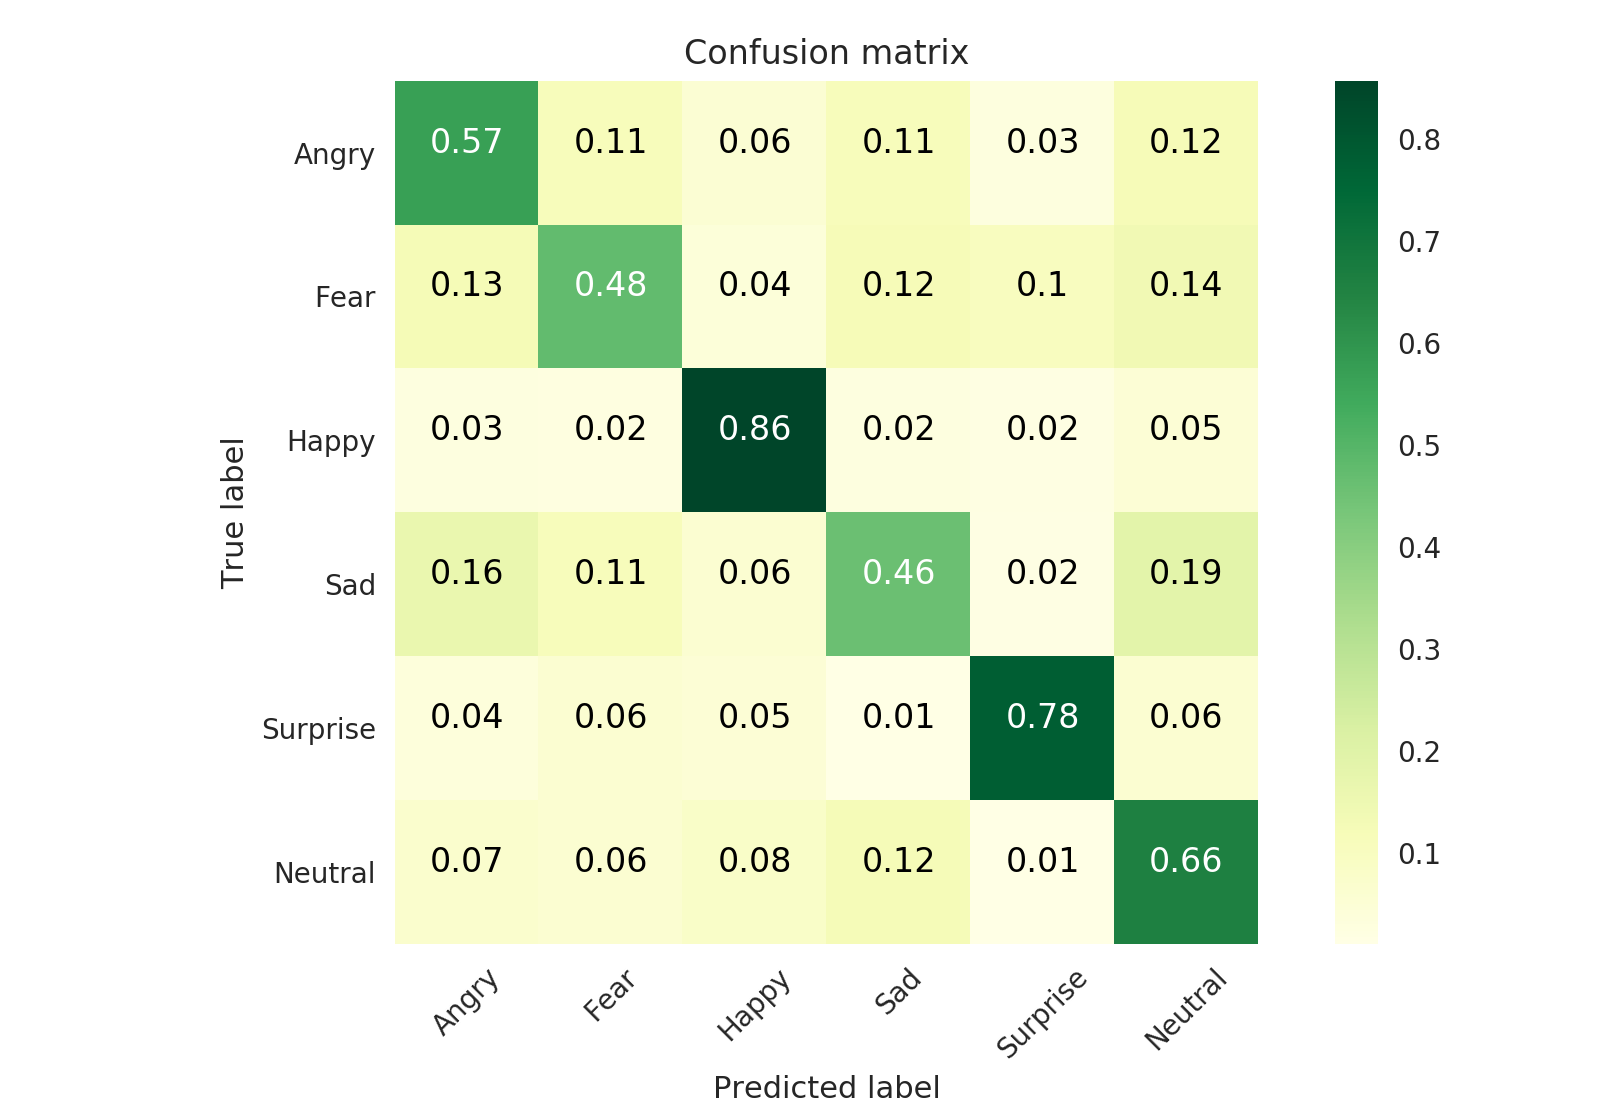

Normalized confusion matrix


/home/theinhtay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [57]:
plot_confusion_matrix(ens_y,test_y,np.array(list(mod_label_dict.values()))[:,0],\
                     normalize=True)
plt.savefig('Ensemble.eps',transparent=True)

In [61]:
score1=np.array(result_dict['test_score'])


In [66]:
len(result_dict['Validation accuracy'])

266

In [67]:
score1[:]

array([[  1000.  ,     41.34],
       [  2000.  ,     51.68],
       [  3000.  ,     59.4 ],
       [  4000.  ,     59.45],
       [  5000.  ,     63.5 ],
       [  6000.  ,     62.38],
       [  7000.  ,     64.08],
       [  8000.  ,     66.24],
       [  9000.  ,     66.02],
       [ 10000.  ,     66.29],
       [ 11000.  ,     65.99],
       [ 12000.  ,     65.96],
       [ 13000.  ,     65.96],
       [ 14000.  ,     65.94]])

<IPython.core.display.Javascript object>


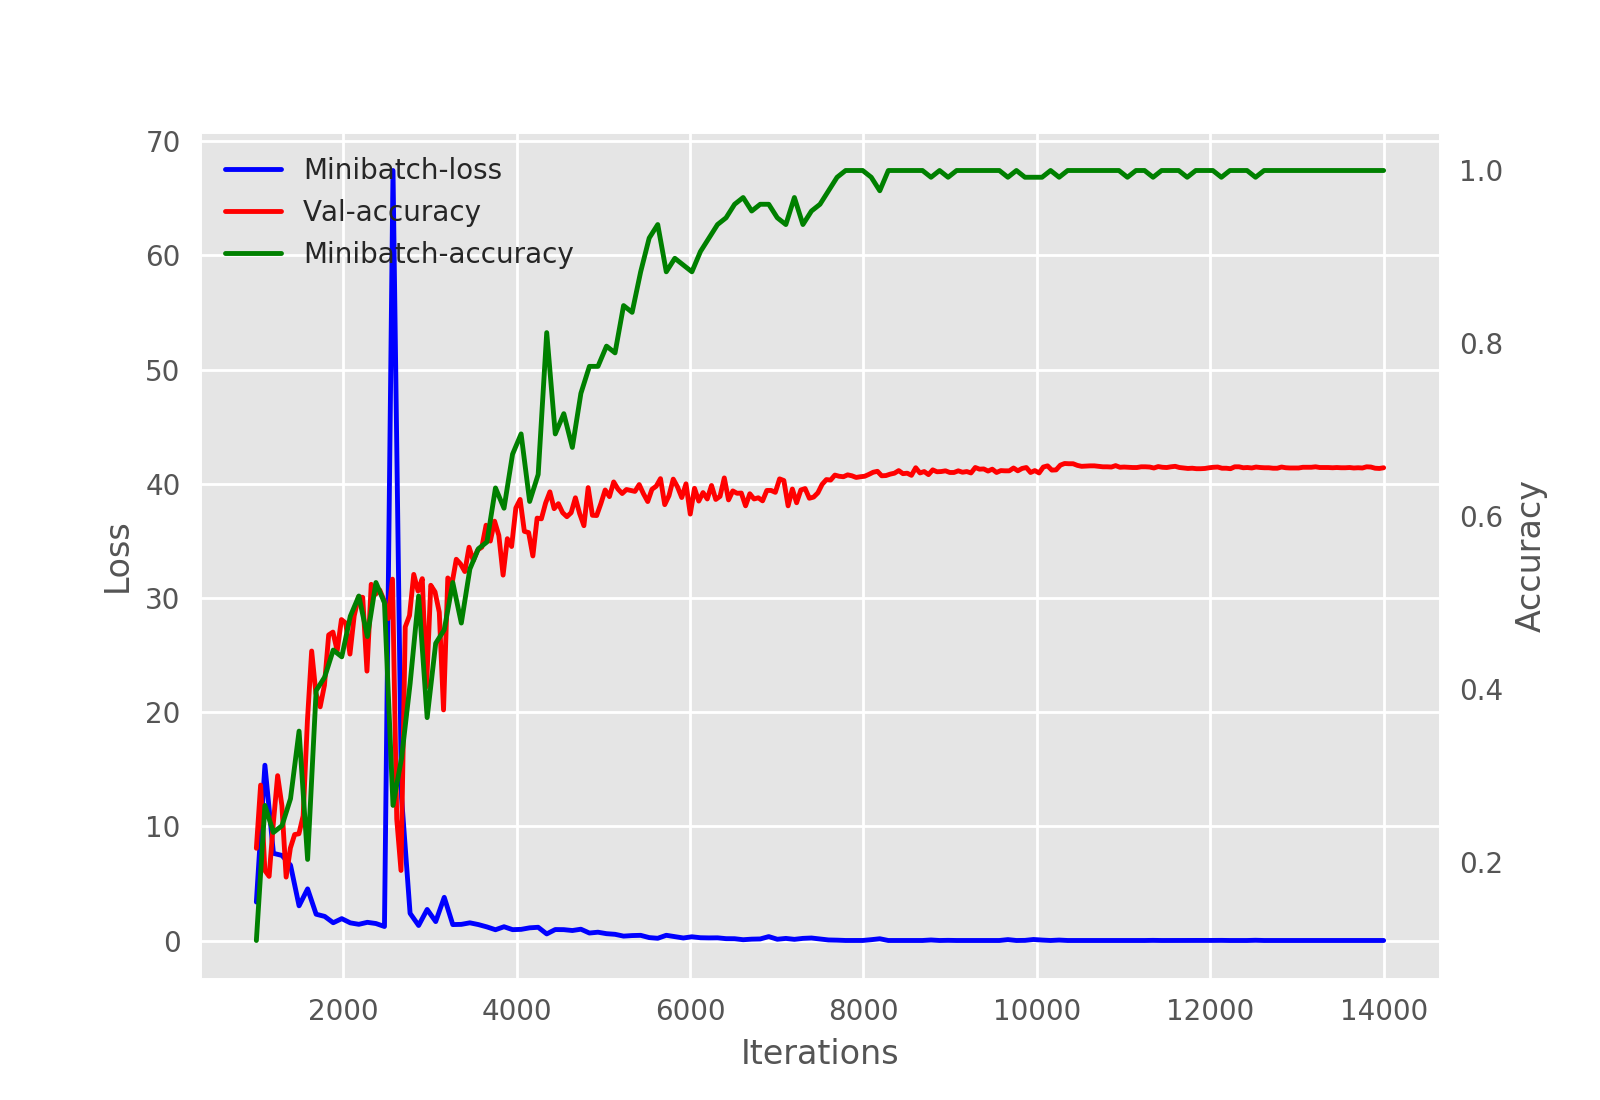

/home/theinhtay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/home/theinhtay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/home/theinhtay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [73]:
import matplotlib as mpl
#mpl.style("ggplot")
plt.style.use('ggplot')

fig,ax=plt.subplots()
#plt.plot(np.linspace(1000,14000,266),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy')
ax.plot(np.linspace(1000,14000,266/2),np.mean(np.array(result_dict['Minibatch loss']).reshape(-1,2),1),label='Minibatch-loss',color='b')
#plt.plot(np.linspace(64,10600,160),np.array(result_dict['V loss']),label='Minibatch-loss')
#plt.legend(loc='center right')
ax2=ax.twinx()
ax2.plot(np.linspace(1000,14000,266),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy',color='r')
ax2.plot(np.linspace(1000,14000,266/2),np.mean(np.array(result_dict['Minibatch accuracy']).reshape(-1,2),1)/100.0,label='Minibatch-accuracy',color='g')
ax.plot(np.nan, '-r', label = 'Val-accuracy')
ax.plot(np.nan, '-g', label = 'Minibatch-accuracy')
ax.legend(loc='upper left')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.grid(False)
fig.savefig('2nd_model_accuracy.eps',transparent=False)

<IPython.core.display.Javascript object>


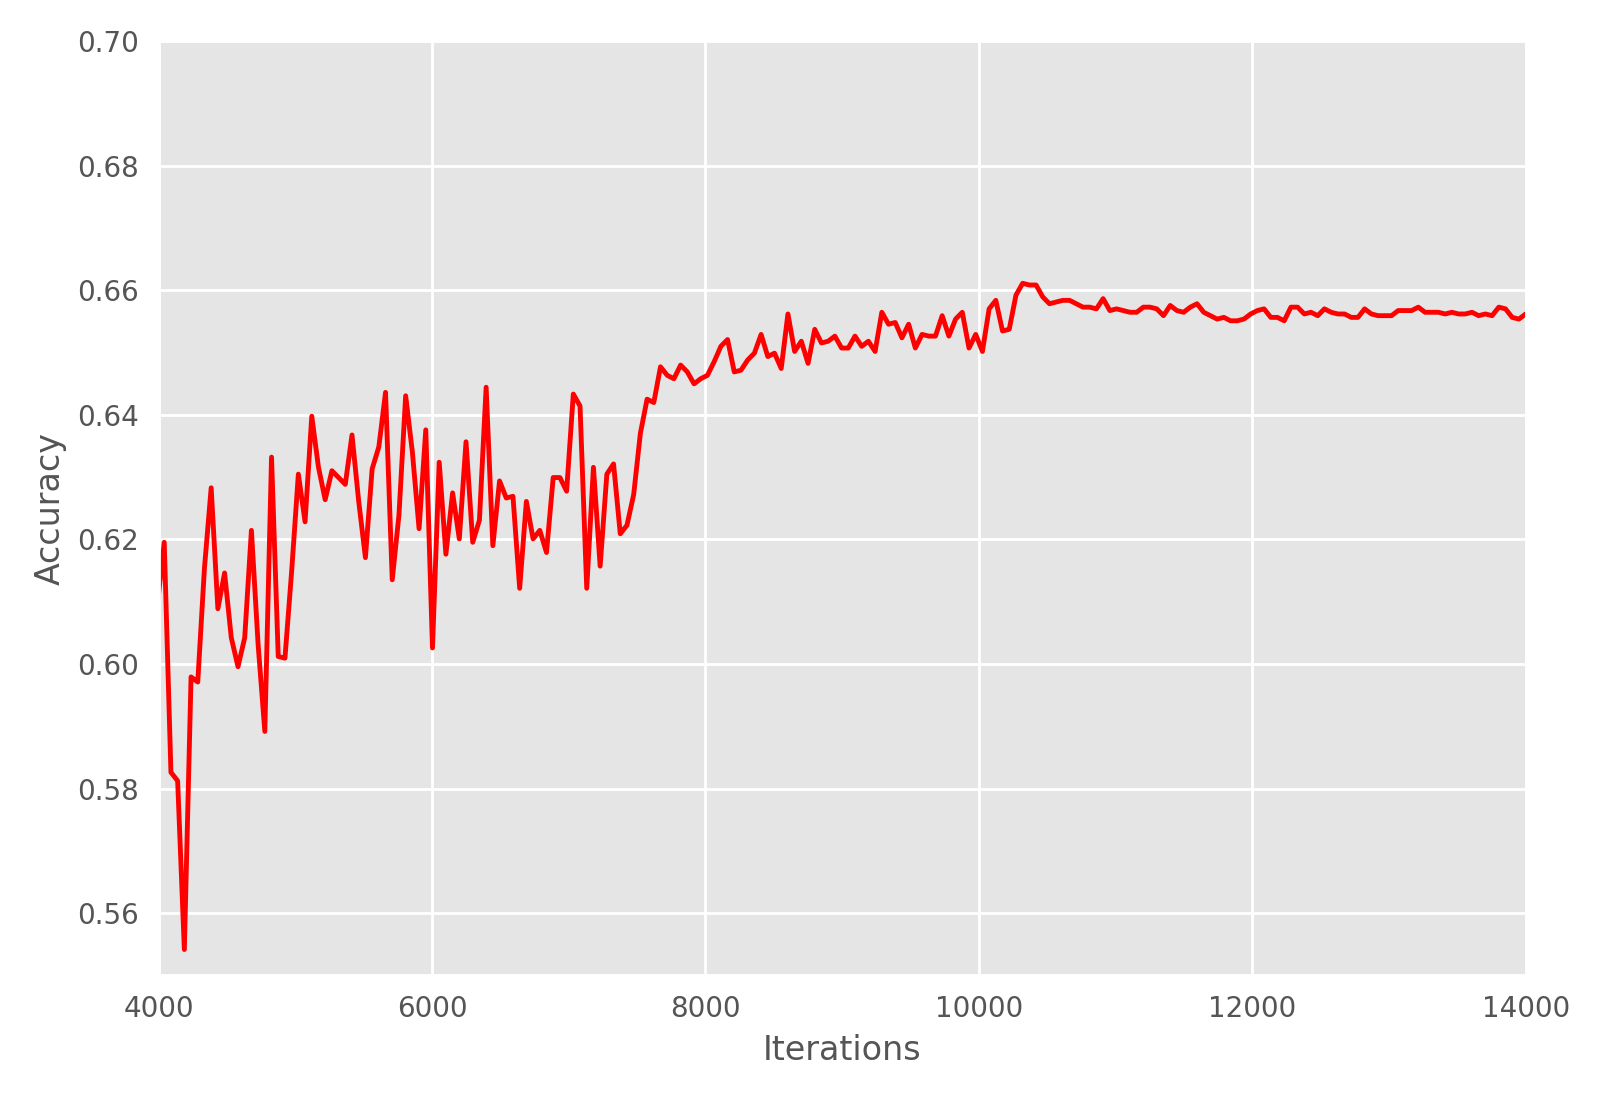

/home/theinhtay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [79]:
plt.style.use('ggplot')

fig,ax=plt.subplots()
#ax.plot(np.linspace(1000,14000,266/2),np.mean(np.array(result_dict['Minibatch accuracy']).reshape(-1,2),1)/100.0,label='Minibatch-accuracy',color='g')
ax.plot(np.linspace(1000,14000,266),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy',color='r')
ax.set_xlim(4000,14000)
ax.set_ylim(0.55,0.7)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iterations')
plt.tight_layout()
fig.savefig('deep_net.eps',transparent=False)